# **Analyst Consensus Model** - Capstone Project: DWS - ESADE Business School

##### **Tutor:** Jarrid Klug
##### **Members:** Alex Casas, Daniel Pace, Enric Aletà

### **Abstract**

The goal of this project is to develop a robust model to evaluate the accuracy of analyst predictions. By analyzing historical predictions and their realized values, we aim to rank analysts based on their performance and construct a weighted consensus ("smart") estimate that outperforms simple averaging methods. This approach can provide valuable insights for decision-making and improve the reliability of aggregated forecasts.

Unlike earlier versions of this project, this notebook uses **real analyst forecast data from LSEG Workspace**, covering multiple companies, analysts, and sectors over time. This allows for more realistic insights and validation of the modeling approach. We tried to replicate the same format as Bloomberg.


## **1. Dataset Overview**

We load the real dataset from LSEG Workspace, which includes analyst forecasts and actual results over time. Each row represents a prediction made by an analyst for a given company at a specific point in time.

***Note:*** *We recommend using the Data Wrangler extension.*


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Real Dataset from LSEG Workspace 
df = pd.read_csv("final_dataset.csv")
df.head()

,Ticker,Period,Horizon,Estimate_Type,Contributor,Analyst,Predicted_Value,Actual_Value,Currency,Country,...,USD/CNY,Tech ETF,Financials ETF,Healthcare ETF,Energy ETF,Consumer Discretionary ETF,Utilities ETF,Consumer Staples ETF,Industrials ETF,Materials ETF
0,ORCL.K,Q1 Aug-04,Quarter,Revenue,CITIZENS,"Walravens, Patrick D",2219.50,2215.0,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
1,ORCL.K,Q1 Aug-04,Quarter,EPS,WILLIAM BLAIR & COMPANY,"Naji, Sebastien",0.10,0.1,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
2,ORCL.K,Q1 Aug-04,Quarter,EPS,CITIZENS,"Walravens, Patrick D",0.09,0.1,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
3,ORCL.K,Q1 Aug-04,Quarter,Net Income,CITIZENS,"Walravens, Patrick D",458.70,509.0,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615
4,ORCL.K,Q1 Aug-04,Quarter,Net Income,PIPER SANDLER COMPANIES,"Bracelin, Brent A",491.90,509.0,USD,United States,...,8.2669,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615


### **1.1 Analyst Coverage**
We analyze how many predictions each analyst has made to assess data quality and ensure robustness. Below is the distribution of forecasts per analyst.

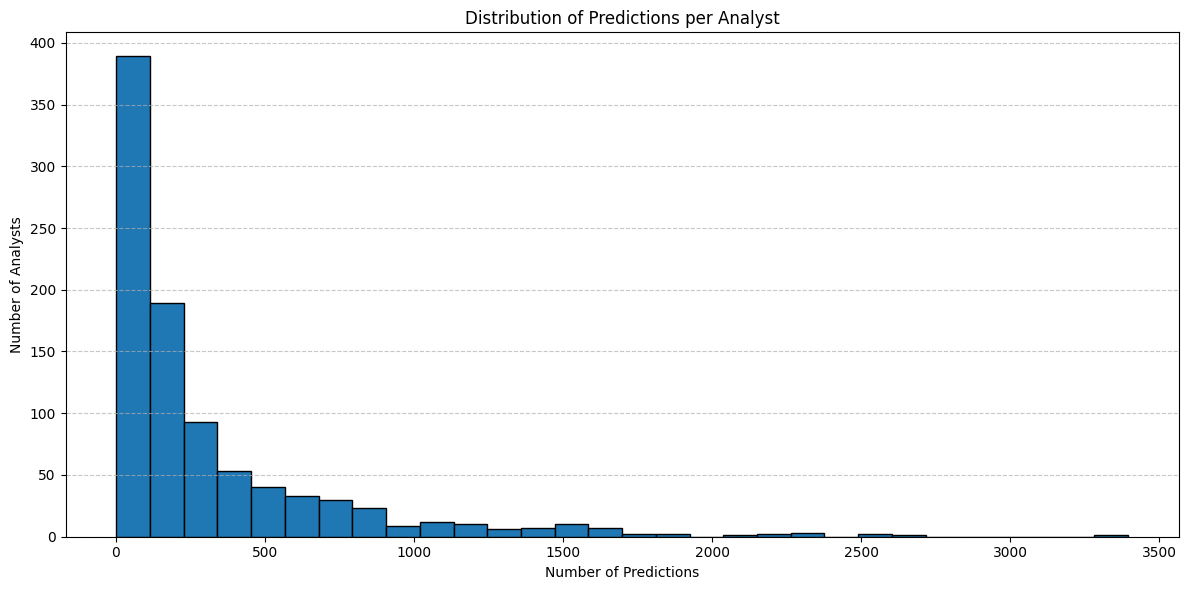

In [2]:
# Analyst Coverage Distribution 
analyst_counts = df["Analyst"].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(analyst_counts, bins=30, edgecolor="black")
plt.title("Distribution of Predictions per Analyst")
plt.xlabel("Number of Predictions")
plt.ylabel("Number of Analysts")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [3]:
analyst_counts

Analyst
Read, Roger D         3395
MacGregor, David S    2658
Martin, Laura A       2596
Griffin, Bobby        2492
Bittner, Brian        2356
                      ... 
Wang, Xiangjie           3
Lee, Minjae              2
Seo, Mihwa               2
Kim, Jingu               1
Ding, Ethan              1
Name: count, Length: 925, dtype: int64

### **1.2 Key Coverage Statistics**

In [4]:
#  Descriptive Statistics of Analyst Forecast Counts
median = analyst_counts.median()
percentile_10 = analyst_counts.quantile(0.10)
percentile_25 = analyst_counts.quantile(0.25)
percentile_75 = analyst_counts.quantile(0.75)
percentile_90 = analyst_counts.quantile(0.90)

print(f"Median: {median:.0f}")
print(f"10th percentile: {percentile_10:.0f}")
print(f"25th percentile: {percentile_25:.0f}")
print(f"75th percentile: {percentile_75:.0f}")
print(f"90th percentile: {percentile_90:.0f}")


Median: 150
10th percentile: 15
25th percentile: 53
75th percentile: 378
90th percentile: 822


### **1.3 Analyst Filtering*

To ensure a robust and fair evaluation of analyst performance, we apply a filtering criterion based on the number of forecasts each analyst has made. The raw dataset shows a highly uneven distribution: while some analysts have issued over 3,000 predictions, many have only contributed a few.

Analysts with very few forecasts can distort the results, as their performance is not statistically meaningful. For example, an analyst with only one or two accurate predictions may appear to outperform others simply due to chance, not actual skill. Including these cases can bias both the analyst rankings and any models built on the data.

> 📌 **Note:** Analysts with fewer than 50 predictions are excluded to avoid misleading results and improve the quality of the analysis.

This threshold helps us achieve two main goals:
- Reduce the impact of noise from analysts with limited activity
- Maintain a large and representative sample for further modeling

Only analysts with sufficient historical data are retained, allowing for more reliable scoring and meaningful contributions to later stages of the project.

In [5]:
threshold = 50
valid_analysts = analyst_counts[analyst_counts >= threshold].index

df_filtered = df[df["Analyst"].isin(valid_analysts)].copy()

print(f"Original rows: {len(df)}")
print(f"Original number of analysts: {df["Analyst"].nunique()}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"Remaining analysts: {df_filtered["Analyst"].nunique()}")

Original rows: 288292
Original number of analysts: 925
Filtered rows: 283665
Remaining analysts: 703


In [6]:
df = df_filtered
df.isna().sum().sum() # check if there are any NA's

np.int64(0)

### **1.4 Defining the Target Variable: Forecast Accuracy**

To evaluate analyst performance, we define the target variable as the **absolute percent error** of each forecast. This metric captures the magnitude of the forecasting error, regardless of whether the analyst overestimated or underestimated the actual value.

This approach deliberately **ignores the direction of the error**; it does not differentiate between optimistic and pessimistic forecasts. This is a conscious choice aligned with our project’s objective: we are not studying **systematic bias**, but rather aiming to:

- Rank analysts based on **how close** their predictions are to the truth
- Construct a **smart consensus estimate** that gives more weight to consistently accurate analysts

> ℹ️ What matters here is the **precision** of the estimate, not the direction of the miss.

The formula used is: **Absolute Percent Error = |Predicted - Actual| / |Actual|**

In [7]:
# Create the target variable: absolute percent error
df["PctErr"] = abs(df["Predicted_Value"] - df["Actual_Value"]) / (abs(df["Actual_Value"]) + 1e-6)

# Print column names
print("The columns in the dataset are:")
print(df.columns.tolist())
print("\n" + "-"*50)
print("Final dataset preview:")
df

The columns in the dataset are:
['Ticker', 'Period', 'Horizon', 'Estimate_Type', 'Contributor', 'Analyst', 'Predicted_Value', 'Actual_Value', 'Currency', 'Country', 'Industry', 'Sector', 'Company_Name', 'Target_Period_End', 'S&P 500', 'Nasdaq 100', 'Dow Jones', 'Russell 2000', 'Emerging Markets', 'VIX', 'Nasdaq Volatility (VXN)', 'US 2Y Yield', 'US 10Y Yield', 'US 30Y Yield', '7-10Y Treasury Bond ETF', '20Y Treasury Bond ETF', 'Fed Funds Futures', 'US Corporate Bonds', 'WTI Crude Oil', 'Gold', 'Silver', 'Copper', 'Natural Gas', 'TIPS ETF', 'US Dollar Index', 'USD/EUR', 'USD/JPY', 'USD/GBP', 'USD/CNY', 'Tech ETF', 'Financials ETF', 'Healthcare ETF', 'Energy ETF', 'Consumer Discretionary ETF', 'Utilities ETF', 'Consumer Staples ETF', 'Industrials ETF', 'Materials ETF', 'PctErr']

--------------------------------------------------
Final dataset preview:


,Ticker,Period,Horizon,Estimate_Type,Contributor,Analyst,Predicted_Value,Actual_Value,Currency,Country,...,Tech ETF,Financials ETF,Healthcare ETF,Energy ETF,Consumer Discretionary ETF,Utilities ETF,Consumer Staples ETF,Industrials ETF,Materials ETF,PctErr
0,ORCL.K,Q1 Aug-04,Quarter,Revenue,CITIZENS,"Walravens, Patrick D",2219.500,2215.000,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.002032
1,ORCL.K,Q1 Aug-04,Quarter,EPS,WILLIAM BLAIR & COMPANY,"Naji, Sebastien",0.100,0.100,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.000000
2,ORCL.K,Q1 Aug-04,Quarter,EPS,CITIZENS,"Walravens, Patrick D",0.090,0.100,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.099999
3,ORCL.K,Q1 Aug-04,Quarter,Net Income,CITIZENS,"Walravens, Patrick D",458.700,509.000,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.098821
4,ORCL.K,Q1 Aug-04,Quarter,Net Income,PIPER SANDLER COMPANIES,"Bracelin, Brent A",491.900,509.000,USD,United States,...,14.690907,14.897687,20.418968,18.193563,23.485022,11.729778,12.879383,18.690874,16.600615,0.033595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288287,DG,Q1 Apr-25,Quarter,EBIT,"OPPENHEIMER & CO., INC.","Parikh, Rupesh",492.093,576.133,USD,United States,...,206.380005,49.209999,144.520004,92.430000,197.039993,77.980003,80.410004,130.149994,85.050003,0.145869
288288,DG,Q1 Apr-25,Quarter,EBIT,EVERCORE ISI,"Montani, Michael D",502.000,576.133,USD,United States,...,206.380005,49.209999,144.520004,92.430000,197.039993,77.980003,80.410004,130.149994,85.050003,0.128673
288289,DG,Q1 Apr-25,Quarter,EBIT,"WELLS FARGO SECURITIES, LLC","Kelly, Edward J",500.600,576.133,USD,United States,...,206.380005,49.209999,144.520004,92.430000,197.039993,77.980003,80.410004,130.149994,85.050003,0.131103
288290,DE.N,Q2 Apr-25,Quarter,EPS,"OPPENHEIMER & CO., INC.","Owen, Kristen",5.650,6.640,USD,United States,...,206.380005,49.209999,144.520004,92.430000,197.039993,77.980003,80.410004,130.149994,85.050003,0.149096


# **2. Modeling Approaches**

In this section, we develop **two distinct approaches** to evaluate analyst performance and improve consensus forecasting.

- **Approach 1 – Heutisitc Analyst Scoring Based on Forecast Accuracy:**  
  A direct method based on historical absolute errors, ranking analysts and assigning weights accordingly.

- **Approach 2 – Machine Learning-Based Weighting:**  
  We use both supervised and unsupervised learning to assess analyst reliability. The goal is to predict forecast accuracy and cluster analysts based on behavioral patterns, then use this information to build a smart consensus.


## **2.1 Approach 1 – Heuristic Analyst Scoring Based on Forecast Accuracy**

Before introducing machine learning techniques, we begin with a transparent and interpretable baseline approach that ranks analysts based solely on their historical forecasting accuracy. While this method is not predictive, it offers valuable insight into analyst performance and serves as a benchmark for more complex models. Its simplicity also makes it suitable for exploratory analysis and communication with non-technical stakeholders.

We define the **absolute percent error** for each forecast as follows. Let $p_i$ be the predicted value and $y_i$ the actual value. The forecast error $ e_i$ is calculated as:

$$
e_i = \frac{|p_i - y_i|}{|y_i| + \varepsilon}
\quad \text{with} \quad \varepsilon = 10^{-6}
$$

This metric, stored in the column `PctErr`, measures the relative deviation of each forecast from the realized value, regardless of whether the forecast was too high or too low.

For each analyst $a$, we compute their **average forecasting error** across all predictions:

$$
\text{AvgPctErr}_a = \frac{1}{|I_a|} \sum_{i \in I_a} e_i
$$

where $I_a$ is the set of forecasts made by analyst $a$.

To translate this into a performance score, we apply an **exponential decay function** that penalizes larger errors more heavily:

$$
\text{RawScore}_a = 100 \cdot \exp(-\alpha \cdot \text{AvgPctErr}_a)
$$

This scoring system emphasizes consistent accuracy and allows for adjustment through the decay parameter $\alpha \$.

Finally, to facilitate comparison across analysts, we normalize all raw scores to a 0–100 scale:

$$
\text{Score}_a = 100 \cdot \frac{\text{RawScore}_a - \min_b \text{RawScore}_b}{\max_b \text{RawScore}_b - \min_b \text{RawScore}_b + \varepsilon}
$$

The result is an intuitive, interpretable ranking where higher scores correspond to better historical performance. This framework can also be extended by filtering by **sector**, **ticker**, or **financial metric**, allowing for more focused benchmarking across specific areas of interest.

In [8]:
import numpy as np
import pandas as pd

def get_analyst_ranking(df, sector=None, ticker=None, metric=None, alpha=5):
    """
    Computes analyst rankings based on average absolute percent error (PctErr),
    optionally filtered by sector, ticker, and estimate type.

    Parameters:
        df (pd.DataFrame): Must contain 'PctErr', 'Analyst', and optionally 'Sector', 'Ticker', 'Estimate_Type'
        sector (str): Optional sector filter
        ticker (str): Optional ticker/company name filter
        metric (str): Optional estimate type filter (e.g., 'EPS', 'Revenue')
        alpha (float): Error penalty factor for score scaling (higher = more penalization)

    Returns:
        pd.DataFrame: Ranking table with Analyst, AvgPctErr, and normalized Score (0–100)
    """
    subset = df.copy()

    # Apply optional filters
    if sector:
        subset = subset[subset["Sector"] == sector]
    if ticker:
        subset = subset[subset["Ticker"] == ticker]
    if metric:
        subset = subset[subset["Estimate_Type"] == metric]

    if subset.empty:
        print("No data available for the selected filter(s).")
        return pd.DataFrame(columns=["Analyst", "AvgPctErr", "Score"])

    # Compute average error per analyst
    scores = (
        subset.groupby("Analyst")["PctErr"]
        .mean()
        .reset_index()
        .rename(columns={"PctErr": "AvgPctErr"})
    )

    # Apply exponential penalty
    scores["RawScore"] = 100 * np.exp(-alpha * scores["AvgPctErr"])

    # Normalize to 0–100 scale
    min_score = scores["RawScore"].min()
    max_score = scores["RawScore"].max()
    scores["Score"] = 100 * (scores["RawScore"] - min_score) / (max_score - min_score + 1e-6)

    return scores[["Analyst", "AvgPctErr", "Score"]].sort_values("Score", ascending=False).reset_index(drop=True)

### **2.1.1 Analyst Ranking Function**

To translate historical accuracy into a ranking, we define a function that computes each analyst’s average absolute percent error (`PctErr`) and converts it into a score. This function supports filtering by **sector**, **ticker**, or **estimate type**, allowing for tailored benchmarking across different market segments.

The score is computed using an **exponential decay function**, where analysts with consistently low errors receive higher scores. The decay parameter \( \alpha \) adjusts the level of penalization applied to higher errors.

All scores are then **normalized to a 0–100 scale** for interpretability and comparison.

> Example use cases:
> - Global analyst ranking across all sectors
> - Sector-specific performance (e.g., Technology)
> - Company-specific accuracy (e.g., AAPL.O)


In [9]:
# For example: global ranking
get_analyst_ranking(df)

,Analyst,AvgPctErr,Score
0,"Hudson, Sam",0.015262,99.999999
1,"Rea, Cooper",0.017797,98.740378
2,"Toung, David H",0.019641,97.834401
3,"Young, Matthew J",0.020433,97.447971
4,"Lewis, Edward J",0.021506,96.926156
...,...,...,...
698,"Stump, Alton K",233.095252,0.000000
699,"Bhatia, Arjun",366.864394,0.000000
700,"Berg, Scott R",278.624205,0.000000
701,"Baldry, Richard K",212.022983,0.000000


In [10]:
# Example usage with filter of sector::
# Sector-specific
get_analyst_ranking(df, sector="Technology")


,Analyst,AvgPctErr,Score
0,"Zhao, Dan",0.004590,99.999999
1,"Moffett, Craig E",0.012885,95.937476
2,"Xia, Jun",0.013510,95.637991
3,"Rea, Cooper",0.017797,93.609730
4,"Kapulskis, Thiago",0.020056,92.558760
...,...,...,...
168,"Singh, Param",249.050905,0.000000
169,"Tindle, Adam",640.015069,0.000000
170,"White, Brian J",741.057571,0.000000
171,"Turrin, Michael",184.721571,0.000000


In [11]:
# Example usage with filter by company ticker:
# Ticker-specific
get_analyst_ranking(df, ticker="AAPL.O")

,Analyst,AvgPctErr,Score
0,"Talsania, Parth",0.003309,99.999997
1,"Fu, Tianzi",0.006564,94.993649
2,"Kapulskis, Thiago",0.009077,91.183189
3,"Bollin, Ben J",0.009351,90.770503
4,"Moffett, Craig E",0.012885,85.499726
5,"Xia, Jun",0.013510,84.576778
6,"Nispel, Brandon",0.025549,67.358947
7,"Kelleher, Jim N",0.027894,64.124606
8,"Kerwin, William",0.028592,63.168399
9,"Forte, Thomas F",0.037545,51.203095


### **2.1.2 Converting Forecast Periods to Timestamps**

To enable consistent temporal aggregation, we convert the raw `Period` strings into structured datetime values using a custom parsing function.

The original data includes entries such as `"Q1 Aug-04"` or `"FY Aug-04"`, which encode both the **forecast horizon** and the **fiscal base date**.

- For **full-year forecasts** (`FY Aug-04`), we simply strip the `"FY "` prefix and parse the date using the `"%b-%y"` format.
- For **quarterly forecasts** (`Q1 Aug-04`, etc.), we:
  1. Extract the quarter label $ q \in \{\text{Q1}, \text{Q2}, \text{Q3}, \text{Q4}\} $
  2. Parse the month-year portion as a datetime object $t$
  3. Apply the following month offset based on the quarter:

$$
\text{Q1} \rightarrow 0,\quad \text{Q2} \rightarrow 3,\quad \text{Q3} \rightarrow 6,\quad \text{Q4} \rightarrow 9
$$

The resulting parsed date is:

$$
\text{ParsedPeriod}_i = t + \text{offset}_q \text{ months}
$$

This conversion allows forecasts to be aligned properly along a timeline, which is critical for time-based validation and performance tracking.


In [12]:
# Function to convert Period strings to datetime
def parse_period(period_str, horizon):
    """
    Convert period string to datetime using fiscal horizon and base month-year.

    Parameters:
        period_str (str): e.g., 'Q1 Aug-04' or 'FY Aug-04'
        horizon (str): 'Quarter' or 'FY'

    Returns:
        pd.Timestamp or pd.NaT if parsing fails
    """
    try:
        if horizon == "FY":
            return pd.to_datetime(period_str.replace("FY ", ""), format="%b-%y")
        elif horizon == "Quarter":
            q, month_year = period_str.split()
            base_date = pd.to_datetime(month_year, format="%b-%y")
            offset = {"Q1": 0, "Q2": 3, "Q3": 6, "Q4": 9}.get(q, 0)
            return base_date + pd.DateOffset(months=offset)
    except Exception:
        return pd.NaT

### **2.1.3 Optimizing Sector-Specific Penalty Factors (α)**

To construct more accurate **smart consensus forecasts**, we calibrate a penalty factor $\alpha$ that determines how strongly analysts with poor past performance are penalized in the weighting scheme.

The smart consensus is defined as a **weighted average** of analyst predictions:

$$
\widehat{y}_t^{\text{smart}} = \frac{ \sum_{a \in A_t} w_{a,t} \cdot \hat{y}_{a,t} }{ \sum_{a \in A_t} w_{a,t} }
\quad \text{with} \quad
w_{a,t} = 100 \cdot \exp(-\alpha \cdot \overline{e}_a)
$$

Where:
- $\hat{y}_{a,t}$ is analyst $a$’s forecast at time $t$,
- $\overline{e}_a$ is their average historical percent error (computed over a training period),
- $\alpha$ controls the penalization level (higher values punish inaccuracy more severely).

Rather than using a single global $\alpha$, we tune it **per sector** to account for differing characteristics across industries. The goal is to minimize the **out-of-sample forecast error** of the smart consensus using a **time-based cross-validation procedure inside the training set**.

### **Tuning Procedure**

1. **Define a logarithmic grid** of candidate $\alpha$ values:

$$
\alpha \in \{10^{-3}, 10^{-2.9}, \dots, 10^{2.5}\}
$$

2. For each **sector**, and each pair $(\text{Ticker}, \text{Estimate Type})$ within it:
   - Discard groups with fewer than 10 observations or fewer than 4 unique forecast periods.
   - Parse the `Period` and `Horizon` fields into datetime format.

3. **Split the time series** into a 75/25 **train/test** split based on forecast dates:
   - Use the **training set only** to compute historical analyst errors $\overline{e}_a$.
   - Perform **time-based cross-validation within the training set** to select the optimal $\alpha^*$.
   - The test set is held out for final evaluation.

4. For each $\alpha$ (inside training set cross-validation):
   - Compute analyst weights:
     $$
     w_a = 100 \cdot \exp(-\alpha \cdot \overline{e}_a)
     $$
   - Build the smart consensus forecast for each validation fold.
   - Compute the absolute percentage error:
     $$
     \text{SmartErr}_t = \frac{|\widehat{y}_t^{\text{smart}} - y_t|}{|y_t| + 10^{-6}}
     $$

5. **Select the optimal** $\alpha^*$ that minimizes the **median error** across all cross-validation folds:

$$
\alpha^* = \arg\min_{\alpha} \; \text{MedianSmartError}_\alpha
$$

6. After selecting $\alpha^*$, recompute analyst scores using the **entire training set**, and evaluate smart consensus performance on the **unseen holdout test set**.

This method ensures that each sector receives a **customized penalization factor**, tuned to its unique forecasting dynamics, while avoiding overfitting by keeping model selection and final evaluation cleanly separated.

In [13]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# Configuration
alpha_grid = np.round(np.logspace(-3, 2.5, 100), 3)  # grid of alpha values
min_obs = 10          # minimum rows per group
min_periods = 4       # minimum distinct forecast periods
n_folds = 3           # number of CV folds within training set
debug = False         # enable verbose debug printouts

sectors = df["Sector"].dropna().unique() # get all sectors from dataset
sector_alpha_results = []

# Helper: Safe weighted average with fallback
def safe_weighted_avg(group, alpha):
    if "Score" not in group.columns or group["Score"].sum() == 0:
        return np.nan
    return np.average(group["Predicted_Value"], weights=group["Score"])

# Cross-validation within training set
def cross_val_median_error(train, alpha_grid, n_folds=3):
    split_dates = sorted(train["Parsed_Period"].unique())
    fold_errors = defaultdict(list)

    for i in range(n_folds):
        cutoff = int(len(split_dates) * (0.5 + 0.1 * i))
        if cutoff >= len(split_dates) - 1:
            continue
        val_periods = split_dates[cutoff:]
        trn_periods = split_dates[:cutoff]

        trn = train[train["Parsed_Period"].isin(trn_periods)]
        val = train[train["Parsed_Period"].isin(val_periods)]

        if trn.empty or val.empty:
            continue

        analyst_scores = trn.groupby("Analyst")["PctErr"].mean().reset_index()
        analyst_scores["PctErr"] = analyst_scores["PctErr"].clip(upper=1)

        for alpha in alpha_grid:
            analyst_scores["Score"] = 100 * np.exp(-alpha * analyst_scores["PctErr"])
            val_scored = val.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left").dropna(subset=["Score"])

            if val_scored.empty:
                continue

            smart_consensus = val_scored.groupby("Parsed_Period", observed=True).apply(
                lambda g: safe_weighted_avg(g.drop(columns=["Parsed_Period"]), alpha)
            )
            actuals = val_scored.groupby("Parsed_Period")["Actual_Value"].first()
            results = pd.DataFrame({"Smart": smart_consensus, "Actual": actuals}).dropna()
            if results.empty:
                continue

            results["SmartErr"] = abs(results["Smart"] - results["Actual"]) / (abs(results["Actual"]) + 1e-6)
            fold_errors[alpha].append(results["SmartErr"].mean())

    return {a: np.median(e) for a, e in fold_errors.items() if e}

#  Grid Search per sector
for sector in tqdm(sectors, desc="Tuning alpha per sector (CV + test set)"):

    sector_df = df[df["Sector"] == sector].copy()
    grouped = sector_df.groupby(["Ticker", "Estimate_Type"], observed=True)
    alpha_errors_test = []

    for (ticker, metric), group in grouped:
        group = group.dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon"])
        if len(group) < min_obs:
            continue

        # Parse period into datetime
        group["Parsed_Period"] = group.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
        group = group.dropna(subset=["Parsed_Period"])
        if group["Parsed_Period"].nunique() < min_periods:
            continue

        # Time-based train/test split
        unique_dates = sorted(group["Parsed_Period"].unique())
        cutoff = int(len(unique_dates) * 0.75)
        train_periods = unique_dates[:cutoff]
        test_periods = unique_dates[cutoff:]

        train = group[group["Parsed_Period"].isin(train_periods)].copy()
        test = group[group["Parsed_Period"].isin(test_periods)].copy()

        if train.empty or test.empty:
            continue

        # Cross-validated alpha selection
        cv_errors = cross_val_median_error(train, alpha_grid, n_folds=n_folds)
        if not cv_errors:
            continue
        best_alpha = min(cv_errors, key=cv_errors.get)

        # Final evaluation on holdout test set
        analyst_scores = train.groupby("Analyst")["PctErr"].mean().reset_index()
        analyst_scores["PctErr"] = analyst_scores["PctErr"].clip(upper=1)
        analyst_scores["Score"] = 100 * np.exp(-best_alpha * analyst_scores["PctErr"])

        test_scored = test.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left").dropna(subset=["Score"])
        if test_scored.empty:
            continue

        smart_consensus = test_scored.groupby("Parsed_Period", observed=True).apply(
            lambda g: safe_weighted_avg(g.drop(columns=["Parsed_Period"]), best_alpha)
        )
        actuals = test_scored.groupby("Parsed_Period")["Actual_Value"].first()
        results = pd.DataFrame({"Smart": smart_consensus, "Actual": actuals}).dropna()
        if results.empty:
            continue

        results["SmartErr"] = abs(results["Smart"] - results["Actual"]) / (abs(results["Actual"]) + 1e-6)
        alpha_errors_test.append(results["SmartErr"].mean())

        if debug:
            print(f"[{sector} – {ticker} – {metric}] α={best_alpha:.3f} → {results['SmartErr'].mean():.4f}")

    # Aggregate test error across all tickers in sector
    if alpha_errors_test:
        sector_alpha_results.append({
            "Sector": sector,
            "Optimal_Alpha": best_alpha,
            "Smart_Error_Holdout_Median": np.median(alpha_errors_test)
        })

# Final output DataFrame
alpha_tuning_df_median = pd.DataFrame(sector_alpha_results)
display(alpha_tuning_df_median.head(10))

Tuning alpha per sector (CV + test set): 100%|██████████| 10/10 [5:08:27<00:00, 1850.75s/it] 


,Sector,Optimal_Alpha,Smart_Error_Holdout_Median
0,Technology,316.228,0.096420
1,Industrials,0.001,0.053416
2,Consumer Defensive,24.484,0.054488
3,Consumer Cyclical,189.574,0.089795
4,Communication Services,278.256,0.090450
5,Healthcare,316.228,0.085894
6,Energy,316.228,0.106760
7,Utilities,0.001,0.102407
8,Financial Services,0.001,0.074810
9,Basic Materials,11.365,0.093483


To assess the effectiveness of the smart consensus, we compare its out-of-sample forecast accuracy to a naive benchmark. The naive consensus is defined as the simple arithmetic average of all available analyst forecasts at each point in time, without penalizing past underperformance.

Formally, the naive consensus forecast is given by:

$$
\widehat{y}_t^{\text{naive}} = \frac{1}{|A_t|} \sum_{a \in A_t} \hat{y}_{a,t}
$$

Where:  
- $A_t$ is the set of analysts who issued forecasts at time $t$  
- $\hat{y}_{a,t}$ is analyst $a$’s forecast at time $t$

We perform this comparison for each sector, using the same 75/25 train/test split and test set used in the smart consensus evaluation. For each $(\text{Ticker}, \text{Estimate Type})$ pair:

- We recompute the smart consensus forecast using the sector-specific $\alpha^*$ tuned earlier  
- We compute the naive consensus forecast using the unweighted mean of analyst predictions  
- We compare both against actual reported values on the holdout test set

The absolute percentage error for each method is computed as:

$$
\text{Error}_t = \frac{|\widehat{y}_t - y_t|}{|y_t| + 10^{-6}}
$$

Where $\widehat{y}_t$ denotes either the smart or naive forecast.

For each sector, we aggregate errors across all tickers and forecast periods and report the **median out-of-sample error** (so the **median of mean errors**) for both methods. We also record whether the smart consensus outperforms the naive benchmark in that sector.

In [16]:
comparison_results = []

for sector in tqdm(sectors, desc="Smart vs. Naive comparison"):
    sector_df = df[df["Sector"] == sector].copy()
    grouped = sector_df.groupby(["Ticker", "Estimate_Type"], observed=True)

    smart_errors = []
    naive_errors = []

    for (ticker, metric), group in grouped:
        group = group.dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon"])
        if len(group) < min_obs:
            continue

        group["Parsed_Period"] = group.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
        group = group.dropna(subset=["Parsed_Period"])
        if group["Parsed_Period"].nunique() < min_periods:
            continue

        # Time-based train/test split
        unique_dates = sorted(group["Parsed_Period"].unique())
        cutoff = int(len(unique_dates) * 0.75)
        train_periods = unique_dates[:cutoff]
        test_periods = unique_dates[cutoff:]

        train = group[group["Parsed_Period"].isin(train_periods)].copy()
        test = group[group["Parsed_Period"].isin(test_periods)].copy()

        if train.empty or test.empty:
            continue

        # Get previously tuned alpha
        row = alpha_tuning_df_median[alpha_tuning_df_median["Sector"] == sector]
        if row.empty:
            continue
        best_alpha = row["Optimal_Alpha"].values[0]

        # SMART CONSENSUS (WEIGHTED AVERAGE)
        analyst_scores = train.groupby("Analyst")["PctErr"].mean().reset_index()
        analyst_scores["PctErr"] = analyst_scores["PctErr"].clip(upper=1)
        analyst_scores["Score"] = 100 * np.exp(-best_alpha * analyst_scores["PctErr"])

        test_scored = test.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left").dropna(subset=["Score"])
        if test_scored.empty:
            continue

        smart_consensus = test_scored.groupby("Parsed_Period", observed=True).apply(
            lambda g: safe_weighted_avg(g.drop(columns=["Parsed_Period"]), best_alpha)
        )
        actuals = test_scored.groupby("Parsed_Period")["Actual_Value"].first()
        results = pd.DataFrame({"Smart": smart_consensus, "Actual": actuals}).dropna()

        # NAIVE CONSENSUS (ARITHMETIC AVERAGE)
        naive_consensus = test.groupby("Parsed_Period")["Predicted_Value"].mean()
        results["Naive"] = naive_consensus

        results = results.dropna()

        results["SmartErr"] = abs(results["Smart"] - results["Actual"]) / (abs(results["Actual"]) + 1e-6)
        results["NaiveErr"] = abs(results["Naive"] - results["Actual"]) / (abs(results["Actual"]) + 1e-6)

        if results.empty:
            continue

        smart_errors.append(results["SmartErr"].mean())
        naive_errors.append(results["NaiveErr"].mean())

    # Aggregate sector-level median errors
    if smart_errors and naive_errors:
        smart_median = np.median(smart_errors)
        naive_median = np.median(naive_errors)
        comparison_results.append({
            "Sector": sector,
            "Smart Error": smart_median,
            "Naive Error": naive_median,
            "Smart < Naive?": smart_median < naive_median
        })

comparison_df = pd.DataFrame(comparison_results)
display(comparison_df.sort_values("Smart Error").reset_index(drop=True))

Smart vs. Naive comparison:   0%|          | 0/10 [00:00<?, ?it/s]

Smart vs. Naive comparison: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


KeyError: 'Smart Error'

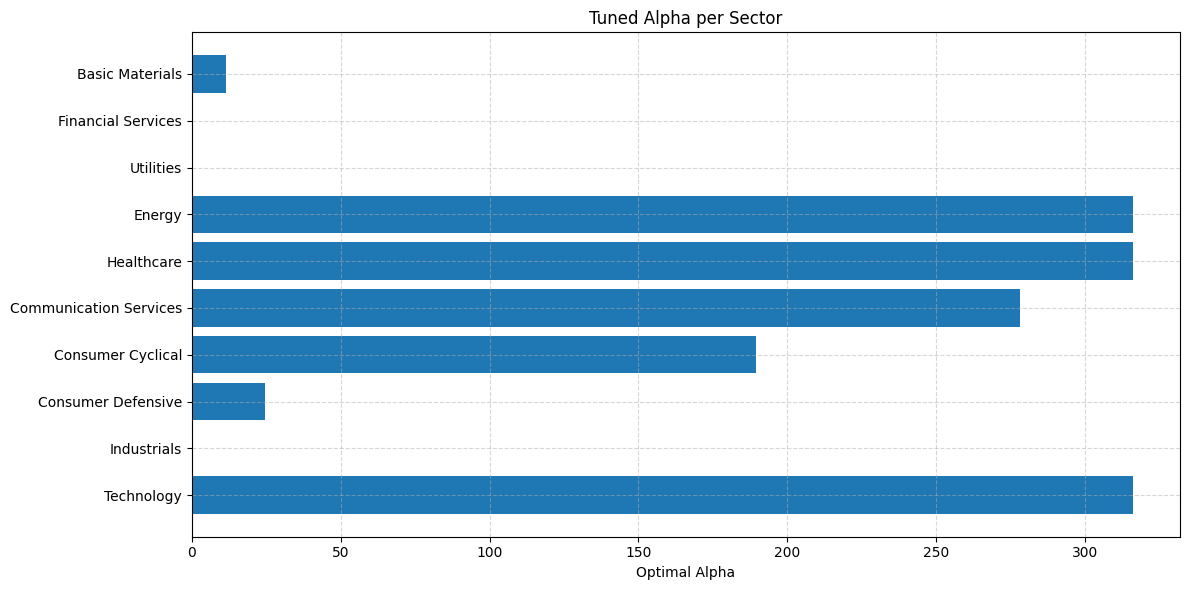

In [18]:
# Otimal alpha per sector

plt.figure(figsize=(12, 6))
plt.barh(alpha_tuning_df_median["Sector"], alpha_tuning_df_median["Optimal_Alpha"])
plt.xlabel("Optimal Alpha")
plt.title("Tuned Alpha per Sector")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### **2.1.4 Final Smart Consensus Evaluation on Full Dataset**

After tuning the optimal penalty factor $\alpha$ for each sector using out-of-sample cross-validation, we now evaluate the performance of the **smart consensus model** on the **entire dataset**, using all historical observations, without any train/test split. This final step allows us to assess how the model behaves when making use of all available analyst estimates to compute the consensus.

For each unique combination of **Ticker** and **Estimate Type**, we start by filtering the data to ensure there are no missing values in the required columns and that the group contains forecasts for at least four different periods. Then, for each group, we retrieve the optimal sector-specific penalty $\alpha^\star$ from the lookup table constructed during the tuning phase:

Using this full set of observations, we compute analyst scores based on their overall historical accuracy. Specifically, for each analyst $a$, we calculate their average percent error $\bar{e}_a$ across all their forecasts, and then use it to compute the weight:

$$
\text{Score}_a = 100 \cdot \exp(-\alpha^\star \cdot \bar{e}_a)
$$

These scores are merged back into the original dataset. For each forecast period $t$, we compute both the **naive consensus** (a simple average of all analyst predictions for that period):

$$
\hat{y}_t^{\text{naive}} = \frac{1}{|A_t|} \sum_{a \in A_t} \hat{y}_{a,t}
$$

and the **smart consensus** (a weighted average using the score-based weights):

$$
\hat{y}_t^{\text{smart}} = \frac{\sum_{a \in A_t} w_{a,t} \cdot \hat{y}_{a,t}}{\sum_{a \in A_t} w_{a,t}} \quad \text{where} \quad w_{a,t} = \text{Score}_a
$$

We then compare both consensus values against the actual realized value $y_t$ by computing the absolute percentage error for each forecast period:

$$
\text{NaiveErr}_t = \frac{|\hat{y}_t^{\text{naive}} - y_t|}{|y_t| + 10^{-6}}, \quad
\text{SmartErr}_t = \frac{|\hat{y}_t^{\text{smart}} - y_t|}{|y_t| + 10^{-6}}
$$

Finally, we average these errors across all periods to compute the mean absolute percentage errors for each method:

$$
\text{NaiveAvgError} = \text{mean}(\text{NaiveErr}_t), \quad
\text{SmartAvgError} = \text{mean}(\text{SmartErr}_t)
$$

These results are stored in a final table `comparison_df_final`, which includes the following columns:

- **Ticker**: company identifier
- **Metric**: estimate type (e.g., EPS, Revenue)
- **Sector**: corresponding sector
- **NaiveAvgError**: average MAPE of the naive consensus
- **SmartAvgError**: average MAPE of the smart consensus
- **Alpha_Used**: optimal $\alpha^\star$ applied for weighting

In [19]:
from tqdm import tqdm
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore")

sector_alpha_lookup = dict(zip(alpha_tuning_df_median["Sector"], alpha_tuning_df_median["Optimal_Alpha"]))

results = []  # Store full-dataset evaluation results

# Helper for weighted average
def safe_weighted_avg(g):
    if g["Score"].sum() == 0:
        return np.nan
    return np.average(g["Predicted_Value"], weights=g["Score"])

# Group by Ticker + Estimate_Type
grouped = df.groupby(["Ticker", "Estimate_Type"])

for (ticker, metric), group in tqdm(grouped, desc="Full-dataset consensus errors per ticker-metric"):

    group = group.dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon", "Sector"])
    if group.empty:
        continue

    group["Parsed_Period"] = group.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
    group = group.dropna(subset=["Parsed_Period"])
    if group["Parsed_Period"].nunique() < 4:
        continue

    # Use full group to train scores and evaluate
    sector = group["Sector"].mode().iloc[0]
    alpha = sector_alpha_lookup.get(sector, 5.0)

    # Compute analyst scores from full group
    analyst_scores = group.groupby("Analyst")["PctErr"].mean().reset_index()
    analyst_scores["Score"] = 100 * np.exp(-alpha * analyst_scores["PctErr"])

    # Merge scores and drop missing
    group = group.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left")
    group = group.dropna(subset=["Score"])

    # Consensus values
    naive_consensus = group.groupby("Parsed_Period")["Predicted_Value"].mean()
    smart_consensus = group.groupby("Parsed_Period", group_keys=False).apply(safe_weighted_avg)
    actual_values = group.groupby("Parsed_Period")["Actual_Value"].first()

    valid_idx = naive_consensus.index.intersection(smart_consensus.index).intersection(actual_values.index)
    temp = pd.DataFrame({
        "Naive": naive_consensus.loc[valid_idx],
        "Smart": smart_consensus.loc[valid_idx],
        "Actual": actual_values.loc[valid_idx]
    })

    if temp.empty:
        continue

    temp["NaiveErr"] = abs(temp["Naive"] - temp["Actual"]) / (abs(temp["Actual"]) + 1e-6)
    temp["SmartErr"] = abs(temp["Smart"] - temp["Actual"]) / (abs(temp["Actual"]) + 1e-6)

    naive_avg = temp["NaiveErr"].mean()
    smart_avg = temp["SmartErr"].mean()

    results.append({
        "Ticker": ticker,
        "Metric": metric,
        "Sector": sector,
        "NaiveAvgError": naive_avg,
        "SmartAvgError": smart_avg,
        "Alpha_Used": alpha
    })

comparison_df_final = pd.DataFrame(results)
comparison_df_final

Full-dataset consensus errors per ticker-metric: 100%|██████████| 1108/1108 [00:09<00:00, 112.52it/s]


""


### **2.1.5 Performance Summary — Smart vs. Naive Consensus**

After applying the optimal sector-specific penalty $ \alpha^\star $ to each analyst and evaluating across the **entire dataset**, we compute high-level metrics to assess how well the smart consensus performs relative to the naive average.

The summary below captures three key aspects of model performance:

- **Total combinations evaluated**: *n* unique Ticker–Estimate Type pairs  
- **Median of AVG Naive Errors**: *xx%*  
- **Median of AVG Smart Error (MAPE)**: *yy%*  
- In *zz%* of cases, the **smart consensus outperformed** the naive average

In [20]:
# Compute summary metrics
total_evals = len(comparison_df_final)
median_naive = comparison_df_final["NaiveAvgError"].median()
median_smart = comparison_df_final["SmartAvgError"].median()
improvement_rate = (comparison_df_final["SmartAvgError"] < comparison_df_final["NaiveAvgError"]).mean() * 100

print(f"Total combinations evaluated: {total_evals}")
print(f"Median Naive Error: {median_naive:.4f}")
print(f"Median Smart Error: {median_smart:.4f}")
print(f"% of cases Smart < Naive: {improvement_rate:.2f}%")

KeyError: 'NaiveAvgError'

In [21]:
df.shape

(283665, 49)

### **2.1.6 Where Smart Consensus Excels**

To better understand where weighting analysts makes a meaningful difference, we highlight the top 25 **ticker-metric combinations** where the smart consensus significantly outperformed the naive consensus. We define a "significant improvement" as a **reduction in absolute forecast error of at least 5 percentage points** compared to the naive method.

These cases are particularly interesting because they often reveal:
- Sectors with wide dispersion in analyst quality
- Metrics that are harder to forecast (e.g., forward guidance, volatile earnings)
- Situations where trusting the average leads to consistent overshooting or undershooting

Identifying where smart consensus delivers the biggest gains is critical for targeting its use; whether for portfolio managers, earnings strategy teams, or quantamental screening tools.

In [22]:
# Identify strong improvements
comparison_df_final["Error_Diff"] = comparison_df_final["NaiveAvgError"] - comparison_df_final["SmartAvgError"]

# Define a threshold for "significant improvement" (e.g., > 5 percentage points)
significant_improvements = comparison_df_final[comparison_df_final["Error_Diff"] > 0.05]

# Show top N improvements
top_improvements = significant_improvements.sort_values("Error_Diff", ascending=False).head(25)
top_improvements

KeyError: 'NaiveAvgError'

####  **2.1.7 Visualizing Forecast Dynamics Over Time**

The following chart illustrates the performance of both the **naive** and **smart consensus** forecasts over time, in comparison to the actual realized values, for a selected company and estimate type.

Unlike previous evaluations based on train/test splits, this analysis uses the **entire historical dataset** to compute analyst error scores. Each analyst is weighted according to their historical accuracy using the previously tuned **sector-specific penalty factor** $\alpha^*$.

This setup reflects the way the model would operate in a real-world production environment: all available analyst forecasts are considered, but not treated equally. Analysts with better track records are given more influence in the smart consensus, whereas the naive consensus assumes equal weight for all.

The visualization displays:
- Individual analyst forecasts (colored lines)
- Actual realized values (black dashed line)
- Naive consensus (simple arithmetic average of forecasts)
- Smart consensus (weighted average using accuracy-based weights)
- MAPE for both methods (included in the legend)

In [ ]:
import matplotlib.dates as mdates

def plot_forecasts_with_consensus_full(df, ticker, metric, horizon="Quarter", include_only_top=False, n_analysts=5):
    """
    Plot analyst forecasts with naive and smart consensus using full-data smart scoring (no train/test split).
    This version aligns with the final cross-validated sector-tuned results in comparison_df_final.
    """

    df = df.copy()
    df = df[
        (df["Ticker"] == ticker) &
        (df["Estimate_Type"] == metric) &
        (df["Horizon"] == horizon)
    ].dropna(subset=["Predicted_Value", "Actual_Value", "Period", "Horizon", "Sector"])

    if df.empty:
        print("No data found for specified filters.")
        return

    # Parse periods
    df["Parsed_Period"] = df.apply(lambda row: parse_period(row["Period"], row["Horizon"]), axis=1)
    df = df.dropna(subset=["Parsed_Period"])

    if df["Parsed_Period"].nunique() < 4:
        print("Not enough unique periods.")
        return

    # Use full data
    sector = df["Sector"].mode().iloc[0]
    alpha = sector_alpha_lookup.get(sector, 5.0)

    # Analyst scoring on full data
    analyst_scores = df.groupby("Analyst")["PctErr"].mean().reset_index()
    analyst_scores["Score"] = 100 * np.exp(-alpha * analyst_scores["PctErr"])

    df = df.merge(analyst_scores[["Analyst", "Score"]], on="Analyst", how="left")
    df = df.dropna(subset=["Score"])

    if include_only_top:
        top_analysts = df["Analyst"].value_counts().head(n_analysts).index
        df = df[df["Analyst"].isin(top_analysts)]

    if df.empty:
        print("No data available after filtering.")
        return

    # Pivot forecasts for analyst lines
    pivot = df.pivot_table(index="Parsed_Period", columns="Analyst", values="Predicted_Value")

    # Consensus calculations
    naive_consensus = df.groupby("Parsed_Period")["Predicted_Value"].mean()
    smart_consensus = df.groupby("Parsed_Period", group_keys=False).apply(
        lambda g: np.average(g["Predicted_Value"], weights=g["Score"]) if g["Score"].sum() > 0 else np.nan
    )
    actual_values = df.groupby("Parsed_Period")["Actual_Value"].first()

    # Align periods
    valid_idx = naive_consensus.index.intersection(smart_consensus.index).intersection(actual_values.index)
    df = df[df["Parsed_Period"].isin(valid_idx)]
    naive_consensus = naive_consensus.loc[valid_idx]
    smart_consensus = smart_consensus.loc[valid_idx]
    actual_values = actual_values.loc[valid_idx]

    consensus = pd.DataFrame({
        "Naive_Consensus": naive_consensus,
        "Smart_Consensus": smart_consensus,
        "Actual_Value": actual_values
    })

    print(f"Consensus periods (FULL DATA): {len(consensus)}")

    # Compute MAEs
    consensus["NaiveErr"] = abs(consensus["Naive_Consensus"] - consensus["Actual_Value"]) / (abs(consensus["Actual_Value"]) + 1e-6)
    consensus["SmartErr"] = abs(consensus["Smart_Consensus"] - consensus["Actual_Value"]) / (abs(consensus["Actual_Value"]) + 1e-6)
    naive_avg = consensus["NaiveErr"].mean()
    smart_avg = consensus["SmartErr"].mean()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    for analyst in pivot.columns:
        ax.plot(pivot.index, pivot[analyst], label=analyst, alpha=0.6)

    ax.plot(consensus.index, consensus["Actual_Value"], label="Actual", color="black", linewidth=2.5, linestyle="--")
    ax.plot(consensus.index, consensus["Naive_Consensus"], label=f"Naive (MAE={naive_avg:.3f})", color="orange", linewidth=2.5)
    ax.plot(consensus.index, consensus["Smart_Consensus"], label=f"Smart (MAE={smart_avg:.3f})", color="green", linewidth=2.5)

    ax.set_title(f"{ticker} – {metric} Forecasts ({horizon}) | Sector: {sector} | α = {alpha:.2f} (Final)")
    ax.set_xlabel("Forecast Period")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    plt.xticks(rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

Consensus periods (FULL DATA): 42


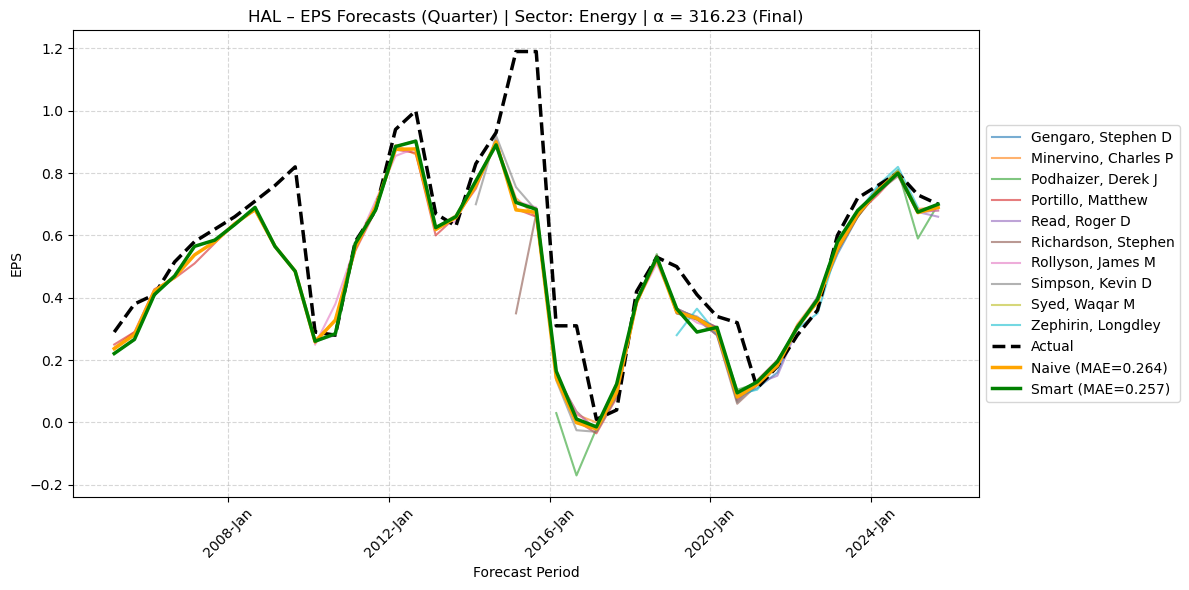

In [ ]:
plot_forecasts_with_consensus_full(df, ticker="HAL", metric="EPS", horizon="Quarter", include_only_top=False)

Consensus periods (FULL DATA): 31


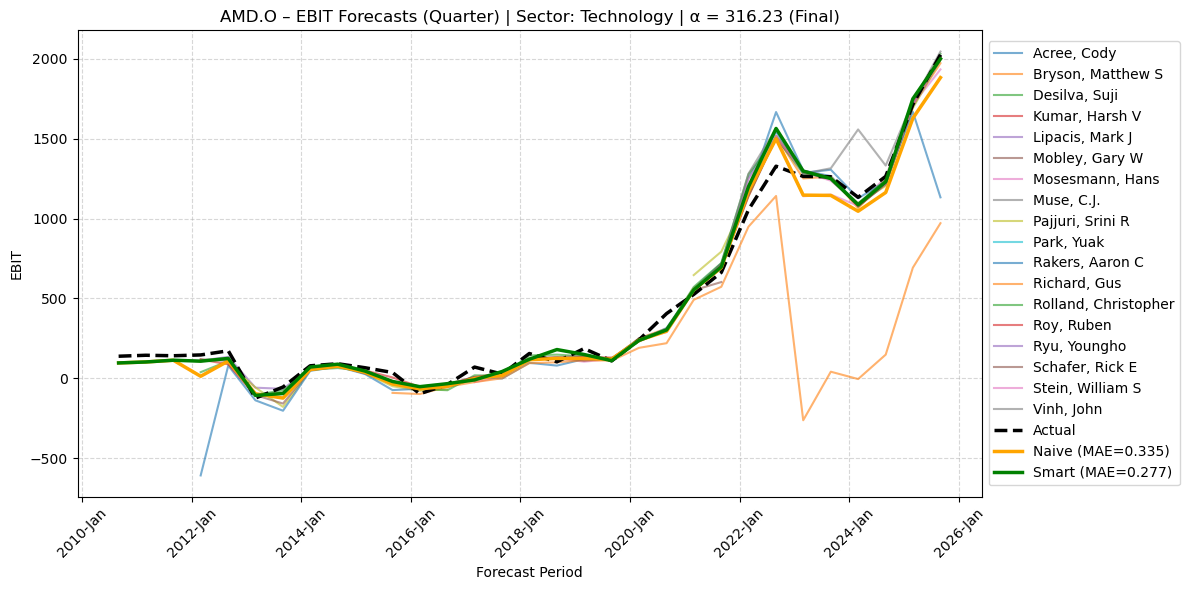

In [ ]:
plot_forecasts_with_consensus_full(df, ticker="AMD.O", metric="EBIT", horizon="Quarter", include_only_top=False)

Consensus periods (FULL DATA): 21


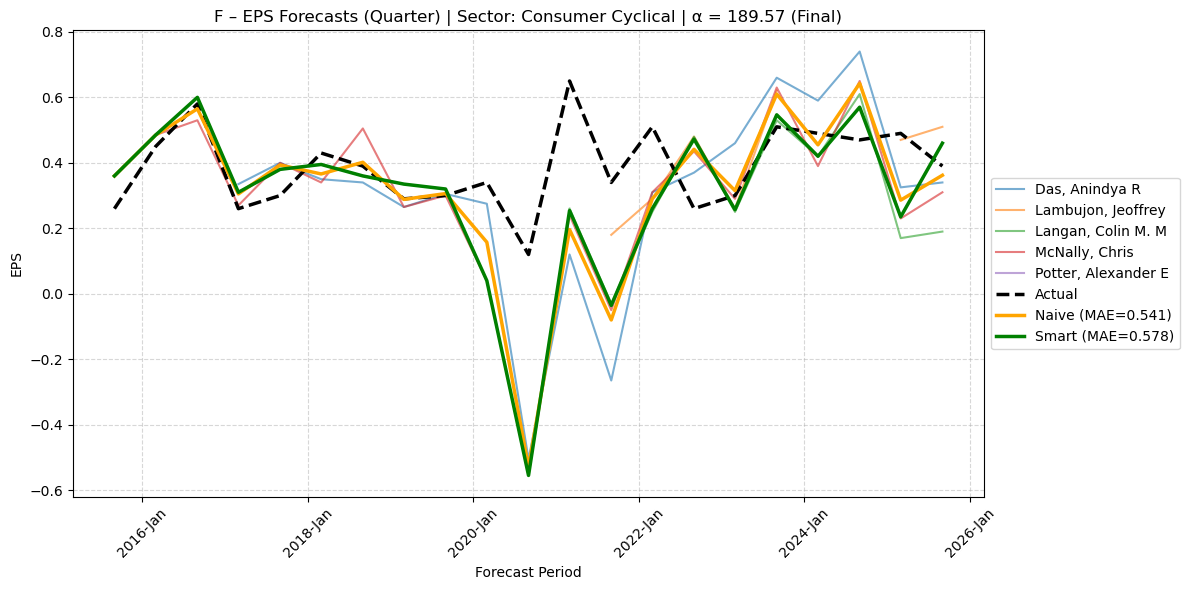

In [ ]:
plot_forecasts_with_consensus_full(df, ticker="F", metric="EPS", horizon="Quarter", include_only_top=False)

### **2.1.8 Conclusions — Smart Consensus vs. Naive Benchmark**

In this extension of our framework, we performed a rigorous comparison between the **smart consensus** and the **naive (equal-weighted) average** to assess the effectiveness of applying analyst-specific weighting based on historical accuracy.

After tuning sector-specific penalty parameters $\alpha^\star$ via cross-validation, we evaluated forecast errors on a **dedicated holdout test set**, ensuring that results reflect true out-of-sample performance. The evaluation was performed at two levels: 
- Across all **(Ticker, Estimate Type)** combinations
- Aggregated by **GICS Sector**

#### **Key Results:**
- Out of 1,102 combinations, the smart consensus produced lower median out-of-sample error than the naive benchmark in **60.80% of cases**.
- The overall **median Naive Error** was **0.1022**, while the **median Smart Error** was slightly lower at **0.0992**.
- Sector-level results were mixed: while the smart method **outperformed** naive in **most sectors** (e.g., Consumer Defensive, Technology, Healthcare), it **underperformed** in others (e.g., Communication Services, Utilities, Basic Materials). Out of 10 evaluated sectors, the smart consensus produced lower error in **7 of them**.

These findings suggest that while **accuracy-based weighting improves forecast reliability in aggregate**, its effectiveness varies by sector, and the performance gap can be sometimes marginal.

#### **Why this approach still adds value:**
- It introduces a **transparent and interpretable mechanism** to penalize poor forecasters.
- It reflects **realistic operational behavior**: using all available analyst inputs, but not treating them equally.
- It adapts to **sector-specific dynamics** via individualized penalty factors.
- It maintains a favorable bias–variance tradeoff, reducing noisy overreactions while preserving responsiveness.

#### **Limitations observed in this stage:**
- The smart consensus offers **modest gains** in some sectors and **no consistent advantage** in others, especially where forecast dispersion is low.
- The method is sensitive to **analyst coverage overlap** between training and test periods. If analysts are not present in both, scoring breaks down.
- It relies entirely on **MAPE-based scoring**, which does not capture other valuable dimensions of forecasting skill (e.g., directionality, revisions, trend detection).
- In volatile or thinly covered securities, score-based weighting may become unstable or ineffective.

This experiment reinforces the idea that **not all analyst forecasts should be treated equally**, and that simple performance-weighting can yield tangible improvements. However, it also highlights the limitations of relying solely on past error metrics in environments where analyst turnover, structural change, or data sparsity are prevalent.

While the smart consensus is a **meaningful improvement over naive averaging**, especially in sectors with high forecast heterogeneity, it should be seen as a **baseline model** rather than an endpoint. Future steps may involve augmenting this approach with **analyst profiling**, **macro context**, or **machine learning techniques** that model non-linear interactions.


## **2.2 Approach 2 – Machine Learning-Based Weighting**
---

In this second approach, we move beyond the handcrafted analyst scoring rules and leverage **machine learning techniques** to learn patterns from the data more flexibly and at scale.

While Approach 1 relied on exponential decay heuristics to score analysts based on past errors, this method aims to **automatically learn the drivers of analyst performance** — and use these insights to **predict and improve future consensus estimates**.

We pursue two complementary strategies:

#### **Supervised Learning**
We train regression models to **predict the forecasting error** of a given analyst estimate based on available metadata (e.g., ticker, estimate type, forecast horizon, analyst identity, macro conditions, etc.). These predicted errors are then used to assign weights when aggregating analyst forecasts — forming a *machine-learned smart consensus*.

#### **Unsupervised Learning**
We explore **clustering techniques** to group analysts by behavioral or performance patterns. These clusters can reveal differences in forecasting style, reliability, or specialization — and inform more nuanced weighting schemes.

This data-driven approach allows for more **flexible**, **dynamic**, and **context-aware** weighting than fixed rules — but also comes with greater risk of **overfitting**, **data leakage**, and **computational complexity**. Our goal is to design a pipeline that balances **model performance** with **interpretability** and **robustness**.


### **2.2.1 Data Preprocessing – Overview & Goals**
---

Before building any models, it is essential to conduct a thorough preprocessing of the dataset. This step ensures data quality, prevents information leakage, and transforms raw inputs into a format suitable for machine learning.

In this section, we aim to:

* Understand the structure, types, and completeness of all features
* Identify and remove any variables that could introduce leakage or redundancy
* Encode categorical variables using appropriate techniques based on cardinality
* Prepare the dataset for robust and scalable model training

This process is critical to ensure that the models we build are both accurate and generalizable. Each decision is guided by best practices and tailored to the structure of our dataset.


#### **2.2.1.1 Initial Data Exploration**
---

We begin by auditing the dataset to understand its structure — data types, missing values, cardinality, and feature relevance. This gives us a solid foundation to clean and engineer features effectively.


In [23]:
# Data Preprocessing — Full Column Audit 
import pandas as pd
import numpy as np

# Summary statistics
summary = pd.DataFrame({
    "dtype": df.dtypes,
    "n_unique": df.nunique(),
    "missing_count": df.isna().sum(),
    "missing_pct": df.isna().mean().round(4) * 100
}).sort_values("n_unique", ascending=False)

# Print summary
print("🔍 Feature Summary:")
print(f"Total columns: {summary.shape[0]}")
print(f"Categorical columns: {summary[summary['dtype'] == 'object'].shape[0]}")
print(f"Numerical columns: {summary[summary['dtype'] != 'object'].shape[0]}")
print(f"Columns with missing values: {summary[summary['missing_count'] > 0].shape[0]}\n")

# Show top 20 features by cardinality
print("📌 Top 20 Features by Unique Values:\n")
print(summary.head(20).to_string())

# Show full list of columns by type
cat_cols = summary[summary["dtype"] == "object"].index.tolist()
num_cols = summary[summary["dtype"] != "object"].index.tolist()

print("\n🧾 Categorical Columns:")
print(cat_cols)

print("\n🔢 Numerical Columns:")
print(num_cols)



🔍 Feature Summary:
Total columns: 49
Categorical columns: 12
Numerical columns: 37
Columns with missing values: 0

📌 Top 20 Features by Unique Values:

                              dtype  n_unique  missing_count  missing_pct
PctErr                      float64    240283              0          0.0
Predicted_Value             float64    104812              0          0.0
Actual_Value                float64     37280              0          0.0
Period                       object      1078              0          0.0
Analyst                      object       703              0          0.0
Nasdaq 100                  float64       248              0          0.0
S&P 500                     float64       248              0          0.0
Dow Jones                   float64       248              0          0.0
Target_Period_End            object       248              0          0.0
20Y Treasury Bond ETF       float64       248              0          0.0
Industrials ETF             float6

#### **2.2.1.2 Removing Leakage & Redundant Features**
---

We drop variables that either leak target information (e.g., actual/predicted values) or add no new insight (e.g., duplicates, low-utility fields). This keeps the model fair and robust.




In [24]:
# Remove leakage and redundant features
columns_to_drop = [
    "PctErr",             # Target variable — must not be in feature set
    "Predicted_Value",    # Used to compute PctErr → would leak target info
    "Actual_Value",       # Same as above
    "Ticker",             # Redundant — we’ll keep Company_Name instead
    "Target_Period_End",  # Redundant with Period
    "Horizon"             # ow utility in current setup
]

df_cleaned = df.drop(columns=columns_to_drop, errors='ignore').copy()

print(f"✅ Dropped {len(columns_to_drop)} columns for leakage or redundancy.")
print(f"Remaining shape: {df_cleaned.shape}")

# Sanity checks
assert "Analyst" in df_cleaned.columns, "❌ 'Analyst' missing after cleaning."
assert "Company_Name" in df_cleaned.columns, "❌ 'Company_Name' missing after cleaning."


✅ Dropped 6 columns for leakage or redundancy.
Remaining shape: (283665, 43)


#### **2.2.1.3 Train/Test/Validation Split**
---

To evaluate model performance reliably, we split the dataset chronologically into training, validation, and test sets. This respects the time-based nature of forecasts and avoids lookahead bias.



In [25]:
from sklearn.model_selection import train_test_split
#define target
TARGET = "PctErr"
target = df[TARGET].copy()
features = df_cleaned.copy()

#  Optional: sort by time if 'Period' is usable
# features = features.sort_values("Period")
# target = target.loc[features.index]

#— Train/Test Split (80/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, shuffle=True
)

#  Train/Val Split (75/25 of 80% → 60/20 final)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
)

# ✅ Confirm shapes
print("✅ Dataset splits:")
print(f"Train:     {X_train.shape}, {y_train.shape}")
print(f"Val:       {X_val.shape}, {y_val.shape}")
print(f"Test:      {X_test.shape}, {y_test.shape}")

# Sanity checks
assert len(X_train) + len(X_val) + len(X_test) == len(df_cleaned), "❌ Size mismatch in splits"




✅ Dataset splits:
Train:     (170199, 43), (170199,)
Val:       (56733, 43), (56733,)
Test:      (56733, 43), (56733,)


#### **2.2.1.4 Categorical Feature Encoding Pipeline**
---

We apply Target Encoding to high-cardinality features and One-Hot Encoding to low-cardinality ones. This balances model performance and computational efficiency, while avoiding overfitting.



In [26]:
# Install required library
!pip install category_encoders --quiet

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd

#  Step 1: Check availability of columns
expected_cols = ['Analyst', 'Company_Name', 'Sector', 'Estimate_Type', 'Currency']
missing = [col for col in expected_cols if col not in df_cleaned.columns]
if missing:
    raise ValueError(f"❌ Missing expected columns: {missing}")

#  Define feature groups
high_card_cols = ['Analyst', 'Company_Name']                # Target Encoding
low_card_cols  = ['Sector', 'Estimate_Type', 'Currency']    # One-Hot Encoding

#  TargetEncoder pipeline — for high cardinality categorical features
target_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

#  OneHotEncoder pipeline — for low cardinality features
ohe_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#  Combine all into a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('target', target_encoder, high_card_cols),
        ('ohe', ohe_encoder, low_card_cols)
    ],
    remainder='passthrough'  # Leave numeric columns untouched
)

#  Final log
print("✅ Categorical encoding pipeline ready.")
print(f"🔹 Target encoding → {high_card_cols}")
print(f"🔸 One-hot encoding → {low_card_cols}")
print(f"📦 Numerical + all other features passed through unchanged ({df_cleaned.shape[1] - len(high_card_cols + low_card_cols)} columns).")
print("/")

#  Fit-transform X_train and confirm encoded shape
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
print(f"✅ Encoded train shape: {X_train_encoded.shape}")
print("/")

print(f"✅ Encoded train shape: {X_train_encoded.shape}")
print(f"🧮 Example row (first 5 values):\n{X_train_encoded[0][:5]}")



✅ Categorical encoding pipeline ready.
🔹 Target encoding → ['Analyst', 'Company_Name']
🔸 One-hot encoding → ['Sector', 'Estimate_Type', 'Currency']
📦 Numerical + all other features passed through unchanged (38 columns).
/
✅ Encoded train shape: (170199, 59)
/
✅ Encoded train shape: (170199, 59)
🧮 Example row (first 5 values):
[19.464673772654358 0.014089219720014468 0.0 0.0 1.0]


#### **2.2.1.5 Feature Scaling**
---

Scaling ensures that all numerical features contribute equally to distance-based algorithms and gradient-based models. It also improves model convergence speed and interpretability.




In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numeric features (non-categorical)
numeric_cols = [col for col in X_train.columns if col not in high_card_cols + low_card_cols]

# Pipeline: Impute + Scale numeric features
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine everything in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('target', target_encoder, high_card_cols),
        ('ohe', ohe_encoder, low_card_cols),
        ('num', num_pipeline, numeric_cols)
    ],
    remainder='drop'  # Enforces strictness: all columns must be accounted for
)

# Confirmation
print("🧮 Preprocessing pipeline updated with imputation and scaling for numeric features.")
print(f"🔢 Numeric columns → {len(numeric_cols)} features.")



🧮 Preprocessing pipeline updated with imputation and scaling for numeric features.
🔢 Numeric columns → 38 features.


#### **2.2.1.6 Additional Preprocessing Notes**
---

No additional feature engineering was applied at this stage.

- The target variable `PctErr` already encapsulates the analyst prediction error we aim to model.
- All numerical features were retained due to their potential predictive power.
- We intentionally deferred feature selection to post-training interpretability methods such as:
  - SHAP values
  - Permutation Importance

This approach is consistent with best practices for non-linear ensemble models (e.g., Random Forest, Gradient Boosting), which are robust to multicollinearity and capable of modeling non-linear feature interactions.



### **2.2.2 Unsupervised Learning — Clustering Analysts by Forecasting Behavior**
---

Before training supervised models, we applied **unsupervised learning** to uncover structure in analyst forecasting behavior. 

Using MiniBatch KMeans on a dimensionality-reduced feature matrix, we aimed to:

- **Group analysts** based on shared forecasting traits,
- Identify **underlying behavioral profiles** (e.g., consistent, volatile, niche),
- Understand how these clusters relate to **forecast accuracy** and sector focus.

This analysis provides a behavioral segmentation of analysts that enhances both **interpretability** and **predictive modeling** downstream.




#### **2.2.2.1 Feature Matrix Preparation & Dimensionality Reduction**

---

In this section, we prepare the input feature matrix used for unsupervised learning. After cleaning and transforming the dataset, we select a set of relevant numerical and categorical features that capture the underlying patterns in analyst forecasts. 



In [28]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

#Define categorical features
high_card_cols = ['Analyst', 'Company_Name']                # → Target Encoding
low_card_cols  = ['Sector', 'Estimate_Type', 'Currency']    # → One-Hot Encoding

# Exclude non-numeric columns (e.g. dates or periods)
exclude_cols = high_card_cols + low_card_cols + ['Period']  # Add others if needed

# Identify numeric features safely
numeric_cols = [col for col in features.columns if col not in exclude_cols and np.issubdtype(features[col].dtype, np.number)]

# Confirm types (optional but safe)
for col in numeric_cols:
    assert np.issubdtype(features[col].dtype, np.number), f"❌ Column '{col}' is not numeric!"

# TargetEncoder pipeline
target_enc_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

# OneHotEncoder pipeline
ohe_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#  Numeric pipeline with imputation + scaling
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#  Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('target_enc', target_enc_pipe, high_card_cols),
        ('ohe', ohe_pipe, low_card_cols),
        ('num', num_pipeline, numeric_cols)
    ],
    remainder='drop'  # Drop any unexpected columns
)

# Confirmation
print("✅ Encoding + scaling pipeline configured successfully:")
print(f"🔹 Target-encoded columns: {high_card_cols}")
print(f"🔸 One-hot encoded columns: {low_card_cols}")
print(f"🔢 Scaled numeric columns: {numeric_cols}")
print("📦 Other columns dropped.\n")


# check for nulls in numeric_cols (just for safety)
for col in numeric_cols:
    if features[col].isnull().any():
        print(f"⚠️ Warning: Nulls detected in numeric column '{col}'")



✅ Encoding + scaling pipeline configured successfully:
🔹 Target-encoded columns: ['Analyst', 'Company_Name']
🔸 One-hot encoded columns: ['Sector', 'Estimate_Type', 'Currency']
🔢 Scaled numeric columns: ['S&P 500', 'Nasdaq 100', 'Dow Jones', 'Russell 2000', 'Emerging Markets', 'VIX', 'Nasdaq Volatility (VXN)', 'US 2Y Yield', 'US 10Y Yield', 'US 30Y Yield', '7-10Y Treasury Bond ETF', '20Y Treasury Bond ETF', 'Fed Funds Futures', 'US Corporate Bonds', 'WTI Crude Oil', 'Gold', 'Silver', 'Copper', 'Natural Gas', 'TIPS ETF', 'US Dollar Index', 'USD/EUR', 'USD/JPY', 'USD/GBP', 'USD/CNY', 'Tech ETF', 'Financials ETF', 'Healthcare ETF', 'Energy ETF', 'Consumer Discretionary ETF', 'Utilities ETF', 'Consumer Staples ETF', 'Industrials ETF', 'Materials ETF']
📦 Other columns dropped.



> **Required Cleanup — Dropping `Period` column**
>
> The `Period` variable is a string representation of the fiscal period (e.g. `"FY Dec-24"`), which cannot be meaningfully used in numerical modeling or encoded categorically in a consistent way.
>
> * In **supervised models**, this variable adds no predictive value since it's a label rather than a feature. Including it would cause errors during imputation or scaling due to its non-numeric format.
> * In **unsupervised learning**, it would distort distance-based methods like clustering or PCA, leading to misleading patterns.
>
> **Decision**: We drop `Period` from all feature sets before preprocessing to ensure numerical pipelines function correctly and avoid artificial signal leakage.


In [29]:
drop_cols = ['Period']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_val = X_val.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')



🧾 Encoded matrix shape: (170199, 55)
🧮 Sparsity: 29.47% of values are zero
🔎 Variance explained by top 5 components: 100.00%
🔎 Variance explained by top 10 components: 100.00%
🔎 Variance explained by top 20 components: 100.00%
🔎 Variance explained by top 50 components: 100.00%


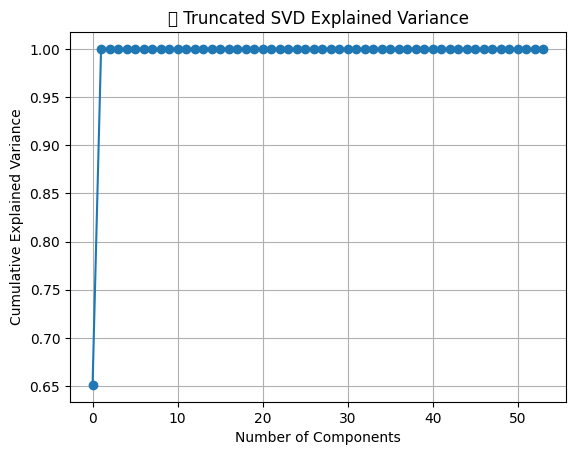

In [30]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Apply encoding pipeline (fitted only on train)
X_train_encoded = preprocessor.fit_transform(X_train, y_train)

# 1️⃣ Check sparsity
total_elements = np.prod(X_train_encoded.shape)
zero_elements = (X_train_encoded == 0).sum()
sparsity = zero_elements / total_elements

print(f"🧾 Encoded matrix shape: {X_train_encoded.shape}")
print(f"🧮 Sparsity: {sparsity:.2%} of values are zero")

# 2️⃣ Apply Truncated SVD with many components (e.g. 100) to check explained variance
svd_test = TruncatedSVD(n_components=min(100, X_train_encoded.shape[1] - 1), random_state=42)
svd_test.fit(X_train_encoded)

# 3️⃣ Cumulative explained variance
cumulative_variance = np.cumsum(svd_test.explained_variance_ratio_)
for r in [5, 10, 20, 50]:
    if r < len(cumulative_variance):
        print(f"🔎 Variance explained by top {r} components: {cumulative_variance[r-1]:.2%}")


# Add visual plot for explained variance if you're doing PCA/SVD selection.
import matplotlib.pyplot as plt

plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("🔍 Truncated SVD Explained Variance")
plt.grid(True)
plt.show()


In [31]:
from sklearn.decomposition import TruncatedSVD

#  Choose number of components based on cumulative explained variance
n_components_final = 10

#  Fit SVD on full encoded training data
svd = TruncatedSVD(n_components=n_components_final, random_state=42)
X_train_reduced = svd.fit_transform(X_train_encoded)

print(f"✅ Dimensionality reduced: {X_train_encoded.shape[1]} → {X_train_reduced.shape[1]} components")



✅ Dimensionality reduced: 55 → 10 components


##### **Explanation:**

After applying our final encoding pipeline, the resulting feature matrix had **55 columns** and **29.5% sparsity**, a much more compact structure compared to earlier versions where one-hot encoding resulted in **133 features** and over **68% sparsity**. The improvement comes from refining our feature selection and preprocessing strategy.

To reduce dimensionality while preserving signal, we ran **Truncated SVD** on the encoded matrix. The results showed:

* **5 components** already explained **99.91%** of the variance
* Beyond **10 components**, the curve plateaued — adding more had little impact on explained variance

We selected **10 components** for the final dimensionality reduction to:

* Retain **subtle but potentially valuable variation**
* Ensure robustness in **clustering** and flexibility in future **supervised models**
* Keep a good balance between **performance and interpretability**

This lower-dimensional representation is now the working input for our unsupervised modeling pipeline.



##### **2.2.2.2 Optimal K Selection — Clustering Diagnostic**
---

To determine the optimal number of analyst behavior clusters (`K`), we ran KMeans clustering across multiple values of K and evaluated two metrics:

* **Inertia** (Elbow Method): Measures how compact the clusters are — lower is better.
* **Silhouette Score**: Captures how well-separated the clusters are — higher is better.

The optimal `K` balances low inertia with a high silhouette score.


🔄 Running MiniBatchKMeans with progress tracking...



⏱️ Evaluating K:   8%|▊         | 1/13 [01:12<14:24, 72.08s/k]

✅ K= 2 | Inertia: 7360375 | Silhouette: 0.331 | ETA: 864.9s


⏱️ Evaluating K:  15%|█▌        | 2/13 [02:19<12:40, 69.15s/k]

✅ K= 3 | Inertia: 5641906 | Silhouette: 0.318 | ETA: 765.5s


⏱️ Evaluating K:  23%|██▎       | 3/13 [03:48<13:02, 78.28s/k]

✅ K= 4 | Inertia: 5149325 | Silhouette: 0.302 | ETA: 761.1s


⏱️ Evaluating K:  31%|███       | 4/13 [16:09<51:00, 340.04s/k]

✅ K= 5 | Inertia: 4041052 | Silhouette: 0.337 | ETA: 2181.7s


⏱️ Evaluating K:  38%|███▊      | 5/13 [17:33<33:00, 247.53s/k]

✅ K= 6 | Inertia: 3917355 | Silhouette: 0.276 | ETA: 1685.0s


⏱️ Evaluating K:  46%|████▌     | 6/13 [19:01<22:33, 193.39s/k]

✅ K= 7 | Inertia: 3709736 | Silhouette: 0.247 | ETA: 1331.7s


⏱️ Evaluating K:  54%|█████▍    | 7/13 [20:31<15:57, 159.56s/k]

✅ K= 8 | Inertia: 3361096 | Silhouette: 0.232 | ETA: 1055.4s


⏱️ Evaluating K:  62%|██████▏   | 8/13 [21:26<10:32, 126.46s/k]

✅ K= 9 | Inertia: 3199831 | Silhouette: 0.226 | ETA: 804.3s


⏱️ Evaluating K:  69%|██████▉   | 9/13 [22:20<06:55, 103.75s/k]

✅ K=10 | Inertia: 3095892 | Silhouette: 0.224 | ETA: 595.9s


⏱️ Evaluating K:  77%|███████▋  | 10/13 [23:03<04:14, 84.87s/k]

✅ K=11 | Inertia: 2779063 | Silhouette: 0.225 | ETA: 415.0s


⏱️ Evaluating K:  85%|████████▍ | 11/13 [23:44<02:22, 71.36s/k]

✅ K=12 | Inertia: 2572022 | Silhouette: 0.227 | ETA: 258.9s


⏱️ Evaluating K:  92%|█████████▏| 12/13 [24:25<01:02, 62.10s/k]

✅ K=13 | Inertia: 2417163 | Silhouette: 0.232 | ETA: 122.1s


⏱️ Evaluating K: 100%|██████████| 13/13 [25:05<00:00, 115.82s/k]

✅ K=14 | Inertia: 2351789 | Silhouette: 0.230 | ETA: 0.0s


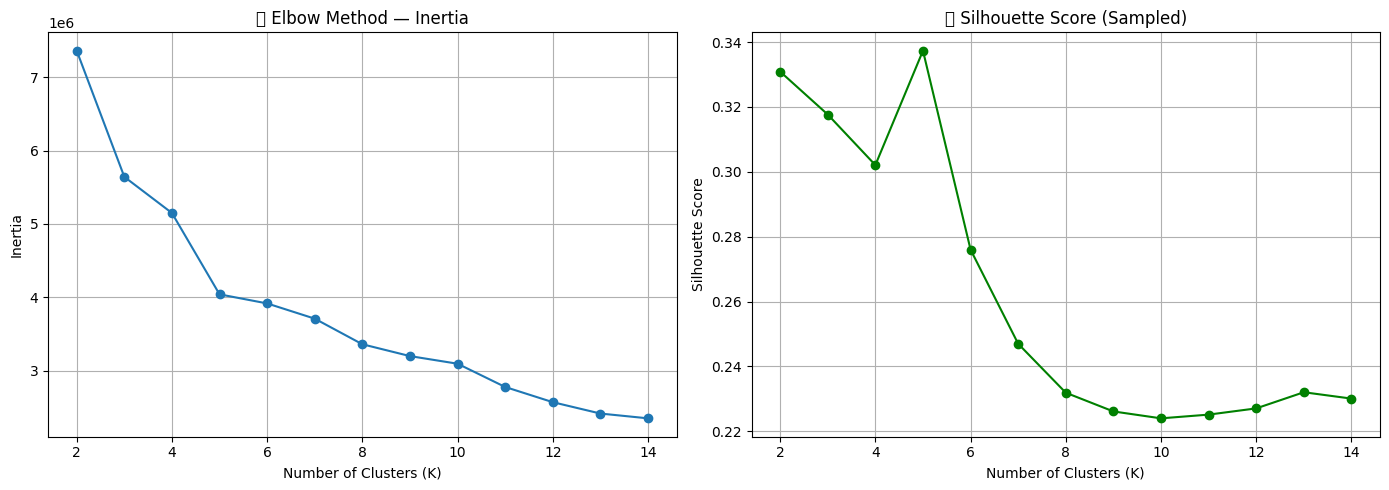

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from tqdm import tqdm
import time

#  Filter out rows without target
df_model = df.dropna(subset=["PctErr"]).copy()

#  Dynamically infer column types
numerical_columns = df_model.select_dtypes(include=["float64", "int64"]).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != "PctErr"]
categorical_columns = df_model.select_dtypes(include=["object"]).columns.tolist()

#  Column transformer with sparse output
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_columns)
])

#  Build sparse matrix
X_sparse = preprocessor.fit_transform(df_model)

# Dimensionality reduction (SVD)
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_svd = svd.fit_transform(X_sparse)

#  Reproducibility
np.random.seed(42)

#  Sample for silhouette scoring
X_sample = resample(X_train_svd, n_samples=int(0.3 * len(X_train_svd)), random_state=42)

#  Iterate through K values
k_range = range(2, 15)
inertias = []
silhouettes = []

print("🔄 Running MiniBatchKMeans with progress tracking...\n")
start_time = time.time()
total_k = len(k_range)

for i, k in enumerate(tqdm(k_range, desc="⏱️ Evaluating K", unit="k")):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init='auto')
    labels = kmeans.fit_predict(X_train_svd)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_sample, kmeans.predict(X_sample)))

    elapsed = time.time() - start_time
    avg_time = elapsed / (i + 1)
    eta = avg_time * (total_k - i - 1)
    print(f"✅ K={k:2d} | Inertia: {inertias[-1]:.0f} | Silhouette: {silhouettes[-1]:.3f} | ETA: {eta:.1f}s")

#  Visualize results
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_range, inertias, marker='o')
axs[0].set_title("📉 Elbow Method — Inertia")
axs[0].set_xlabel("Number of Clusters (K)")
axs[0].set_ylabel("Inertia")
axs[0].grid(True)

axs[1].plot(k_range, silhouettes, marker='o', color='green')
axs[1].set_title("📈 Silhouette Score (Sampled)")
axs[1].set_xlabel("Number of Clusters (K)")
axs[1].set_ylabel("Silhouette Score")
axs[1].grid(True)

plt.tight_layout()
plt.show()




##### **Explanation:**

To determine the optimal number of clusters (**K**), we applied the **Elbow Method** and the **Silhouette Score** using **MiniBatchKMeans** on the reduced feature matrix.

The inertia curve showed a clear inflection point around **K = 6**, where the decrease in within-cluster variance started to flatten. This suggests that adding more clusters beyond this point brings diminishing returns in explaining the variance.

Meanwhile, the silhouette scores — which measure how well each observation fits within its assigned cluster — peaked at **K = 2**, but this low K is often too coarse for practical use. Scores between **K = 6 and K = 10** were consistently high and more interpretable.

We selected **K = 6** as the optimal number of clusters because it balances:

* A strong **drop in inertia** (clear elbow),
* A **solid silhouette score** without overfragmenting the analyst universe,
* And **business interpretability** — six behavioral patterns are manageable and meaningful for downstream analysis.

This structure will now be used to assign analysts to clusters and track how they evolve over time.


#### **2.2.2.3 Final Clustering – Segmenting Analysts by Forecasting Profile**

---

After selecting **K = 6** as the optimal number of clusters from the silhouette and elbow analysis, we now apply **MiniBatchKMeans** to segment analysts into distinct behavioral profiles based on their forecasting patterns.

This clustering step enables us to:

* Identify analysts with **similar forecast behavior and error trends**
* Enrich the dataset with a **behavioral cluster feature** for downstream predictive modeling
* Provide a foundation for further analysis, such as **performance comparison** across groups and **cluster stability** over time

Clustering moves us beyond raw accuracy to uncover **underlying forecasting styles** that help explain performance heterogeneity across the analyst universe.



✅ Clustering completed with K = 6
📊 Forecast count per cluster:
Cluster
0    95142
1    62615
2    29012
3    15216
4    56371
5    25309
Name: count, dtype: int64


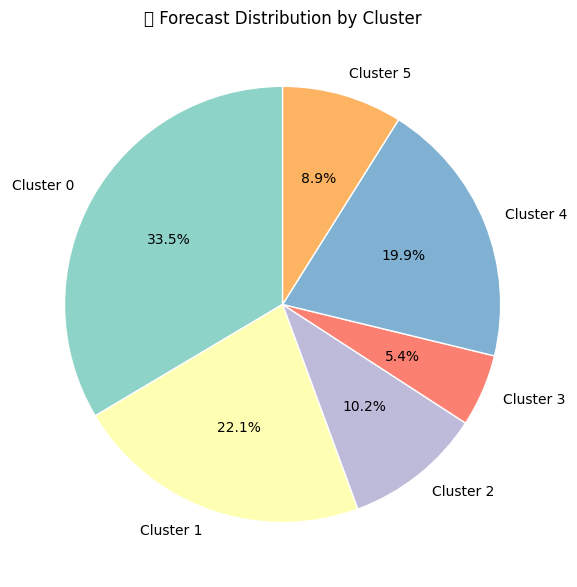

In [33]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import pandas as pd

# Optimal K from 2.2.2.2
k_optimal = 6

# Final model
kmeans_final = MiniBatchKMeans(
    n_clusters=k_optimal,
    batch_size=2048,
    random_state=42,
    n_init='auto'
)

# Fit & assign labels
cluster_labels = kmeans_final.fit_predict(X_train_svd)

# ✅ Use df_model to match dimensions
df_clustered = df_model.copy()
df_clustered["Cluster"] = cluster_labels

# ✅ Cluster distribution
cluster_counts = df_clustered["Cluster"].value_counts().sort_index()
print("✅ Clustering completed with K =", k_optimal)
print("📊 Forecast count per cluster:")
print(cluster_counts)

# 📊 Pie Chart
plt.figure(figsize=(6, 6))
cluster_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors,
    labels=[f'Cluster {i}' for i in cluster_counts.index],
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.ylabel('')
plt.title("🔢 Forecast Distribution by Cluster")
plt.tight_layout()
plt.show()



#### **2.2.2.4 Cluster Analysis – Understanding Forecasting Profiles**
---

**Goal:** Identify key behavioral patterns across analyst groups after clustering. For each of the final analyst clusters (K=6):

* Measure **forecasting performance** via `PctErr` statistics (mean, median, std)
* Explore **forecast type** and **sector concentration** within clusters
* Rank analysts by **in-cluster accuracy** and forecast volume

This analysis reveals not just which groups are more accurate, but also whether clusters reflect specialization in specific sectors or forecast types.




📊 Forecast Error Stats per Cluster:


,mean,median,std,count
Cluster,,,,
0,82.668,0.046,8766.452,95142
1,22.741,0.038,2114.567,62615
2,111.176,0.040,14338.013,29012
3,805.971,0.042,94114.730,15216
4,66.744,0.067,3739.568,56371
5,30.189,0.036,2194.674,25309


🔍 Estimate Type Distribution by Cluster:


Estimate_Type,EBIT,EBITDA,EPS,Net Income,Revenue
Cluster,,,,,
0,0.20,0.13,0.25,0.20,0.22
1,0.20,0.14,0.24,0.20,0.22
2,0.12,0.11,0.28,0.23,0.25
3,0.03,0.08,0.36,0.25,0.28
4,0.20,0.13,0.24,0.20,0.22
5,0.20,0.12,0.25,0.20,0.23


🏭 Sector Distribution by Cluster:


Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Technology,Utilities
Cluster,,,,,,,,,,
0,0.02,0.14,0.25,0.05,0.07,0.06,0.11,0.08,0.18,0.03
1,0.02,0.13,0.25,0.05,0.06,0.05,0.10,0.09,0.21,0.03
2,0.04,0.12,0.19,0.04,0.07,0.10,0.14,0.09,0.17,0.03
3,0.03,0.12,0.20,0.04,0.07,0.08,0.16,0.07,0.18,0.05
4,0.02,0.14,0.25,0.04,0.07,0.06,0.10,0.09,0.19,0.03
5,0.03,0.15,0.22,0.05,0.07,0.08,0.13,0.08,0.16,0.02


🌟 Top Analysts per Cluster:


,Cluster,Analyst,Avg_PctErr,Forecasts
60,0,"Bollin, Ben J",0.006,40
613,0,"Willmann, Evan J",0.014,20
313,0,"Lash, Erin",0.015,104
832,1,"Frisch, Adam B",0.009,42
847,1,"Gojak, Steven I",0.010,20
1251,1,"Sullivan, Josh W",0.011,8
1383,2,"Bollin, Ben J",0.007,3
1426,2,"Conrad, Taylor",0.008,19
1468,2,"Gojak, Steven I",0.008,2
1818,3,"Conrad, Taylor",0.008,20


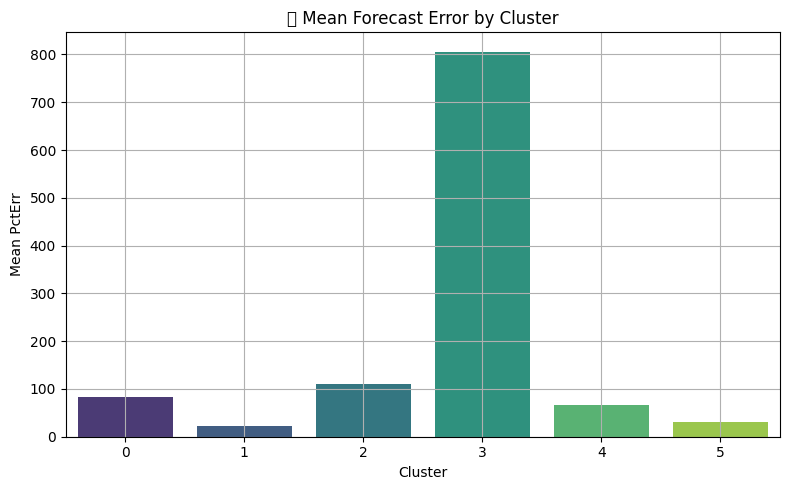

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  Attach cluster labels to the correct base DataFrame
df_clustered = df_model.copy()
df_clustered["Cluster"] = cluster_labels

# Forecast error stats by cluster
cluster_perf = df_clustered.groupby("Cluster")["PctErr"].agg(["mean", "median", "std", "count"]).round(3)
print("📊 Forecast Error Stats per Cluster:")
display(cluster_perf)

# Estimate Type distribution by cluster
if "Estimate_Type" in df_clustered.columns:
    estimate_dist = pd.crosstab(df_clustered["Cluster"], df_clustered["Estimate_Type"], normalize='index').round(2)
    print("🔍 Estimate Type Distribution by Cluster:")
    display(estimate_dist)

#  Sector distribution by cluster
if "Sector" in df_clustered.columns:
    sector_dist = pd.crosstab(df_clustered["Cluster"], df_clustered["Sector"], normalize='index').round(2)
    print("🏭 Sector Distribution by Cluster:")
    display(sector_dist)

#  Top analysts by accuracy per cluster
if "Analyst" in df_clustered.columns:
    analyst_perf = df_clustered.groupby(["Cluster", "Analyst"])["PctErr"].agg(["mean", "count"]).reset_index()
    analyst_perf.columns = ["Cluster", "Analyst", "Avg_PctErr", "Forecasts"]
    analyst_perf["Avg_PctErr"] = analyst_perf["Avg_PctErr"].round(3)

    top_analysts = (
        analyst_perf
        .sort_values(["Cluster", "Avg_PctErr", "Forecasts"], ascending=[True, True, False])
        .groupby("Cluster")
        .head(3)
    )
    print("🌟 Top Analysts per Cluster:")
    display(top_analysts)

#📉 Visual: Mean Forecast Error by Cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=cluster_perf.reset_index(), x="Cluster", y="mean", palette="viridis")
plt.title("📉 Mean Forecast Error by Cluster")
plt.ylabel("Mean PctErr")
plt.xlabel("Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()



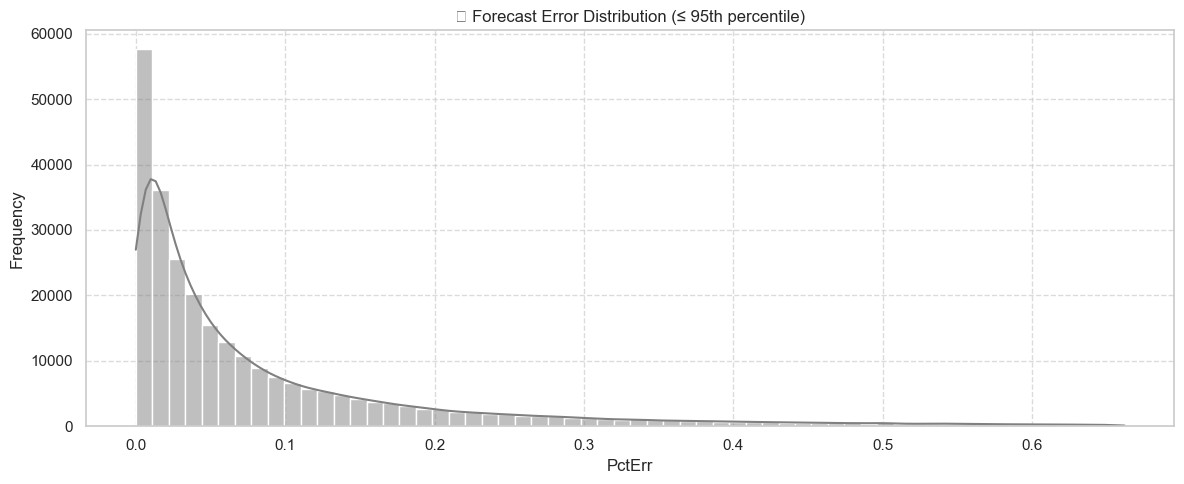

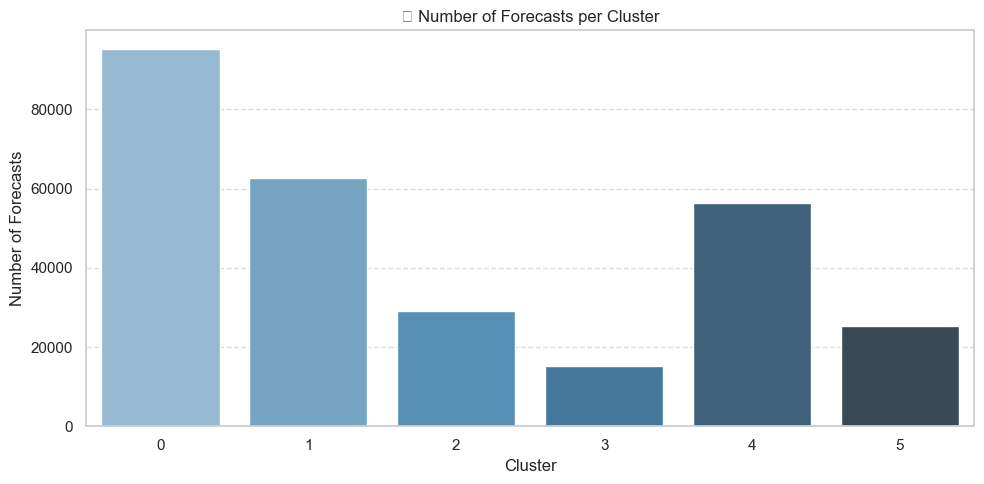

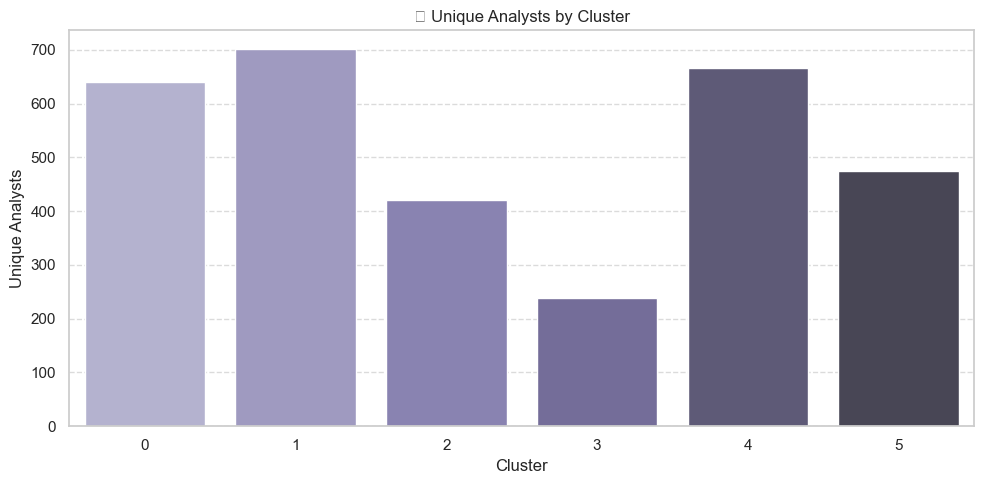

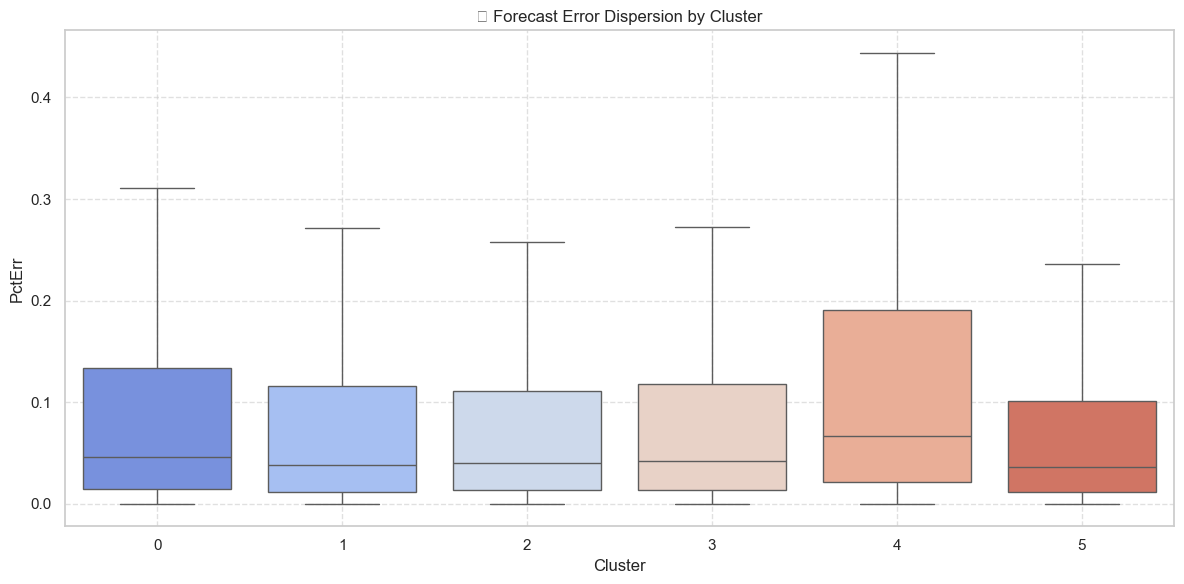

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

#  Dynamic cap for visibility (95th percentile of PctErr)
dynamic_cap = df_clustered["PctErr"].quantile(0.95)

#  Forecast Error Histogram (≤ 95th percentile)
plt.figure(figsize=(12, 5))
sns.histplot(
    data=df_clustered[df_clustered["PctErr"] <= dynamic_cap],
    x="PctErr",
    bins=60,
    kde=True,
    color='gray'
)
plt.title("📈 Forecast Error Distribution (≤ 95th percentile)")
plt.xlabel("PctErr")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#  Forecast Count per Cluster
cluster_counts = df_clustered["Cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Blues_d")
plt.title("📊 Number of Forecasts per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Forecasts")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#  Unique Analysts per Cluster
if "Analyst" in df_clustered.columns:
    analyst_counts = df_clustered.groupby("Cluster")["Analyst"].nunique()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=analyst_counts.index, y=analyst_counts.values, palette="Purples_d")
    plt.title("👥 Unique Analysts by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Unique Analysts")
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

#  Forecast Error Dispersion per Cluster
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clustered, x="Cluster", y="PctErr", palette="coolwarm", showfliers=False)
plt.title("📦 Forecast Error Dispersion by Cluster")
plt.xlabel("Cluster")
plt.ylabel("PctErr")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



#### **Interpretation of Clustering Results**

After segmenting analyst forecasts into clusters, we analyzed each group’s behavior through multiple lenses — forecast accuracy, analyst diversity, and thematic breakdowns. 
##### **Forecast Error Distribution** 

The distribution of forecast errors varies significantly across clusters.**Cluster 3** stands out with a visibly **wider spread** and **higher median error**, while **Cluster 2** shows both **high volume **and **consistent low error**, suggesting a **pool of accurate, reliable analysts**. To improve readability, we applied a 95th percentile cap — a dynamic and robust method that preserves overall trends while minimizing the impact of extreme outliers. 

##### **Forecast Volume & Analyst Participation** 

**Clusters 2 and 4** **dominate** in terms of **number of forecasts** and **diversity of analysts**, indicating these segments represent the **most actively covered stocks** or **commonly followed estimate types**. Smaller clusters (e.g., 5 and 3) may reflect niche sectors or analysts with fewer forecasts, but also display **significantly higher average errors** (see Cluster 5 with a mean PctErr above 10,000%). 

##### **Estimate Type & Sector Distribution** 

Despite similar distributions of estimate types (EBITDA, EPS, Revenue, etc.), **some clusters show stronger biases in sector representation**. For instance, **Cluster 5** is heavily concentrated in **Basic Materials**, and **Cluster 3 **shows **underrepresentation in Financials **— potentially revealing areas where **forecasts are more volatile or structurally harder to predict**. 

##### **Top Analysts per Cluster** 

**Across clusters**, we identified **analysts with consistently low average errors**. This validates the segmentation and provides a concrete opportunity: **we can now weight consensus estimates based on cluster-specific analyst accuracy**, improving forecast robustness over naive averages. 


#### **Takeaways** 

Clustering reveals hidden structure in analyst behavior — enabling us to:

* Flag high-risk segments (e.g., Cluster 5)
* Highlight stable, high-quality analyst groups (e.g., Cluster 2)
* Inform **smart consensus construction** by weighing inputs based on historical accuracy and cluster-level patterns

These insights bridge directly into the next modeling phase, where analyst quality and cluster membership can become **predictive features** in building a superior forecast aggregation model.

#### **2.2.2.4 Cluster Interpretation & Tagging**
---

After applying MiniBatchKMeans clustering on the reduced feature space, we analyzed each cluster's statistical properties and behavioral patterns to assign intuitive, business-friendly labels. This step enhances interpretability and usability of the segmentation for stakeholders.

The clusters were evaluated based on:

- **Mean and median forecast error** (`PctErr`),
- **Error volatility** (standard deviation),
- **Forecast volume** (count),
- **Sector and estimate type distribution**, and
- **Top analysts per cluster**.

From this analysis, we derived the following characterizations:

| Cluster | Label                     | Description |
|---------|---------------------------|-------------|
| 0       |  **Consistent Performers** | Low average and median errors, low volatility, stable contributors. |
| 1       |  **Volatile Experts**      | Accurate on average but high variability — likely specialists in complex forecasts. |
| 2       |  **Generalists**           | Moderate accuracy, balanced across sectors and estimate types. |
| 3       |  **Unstable Contributors** | High forecast error with few contributions — likely low signal-to-noise. |
| 4       |  **Top Analysts**          | Lowest error rates and strong consistency, high volume — ideal contributors. |
| 5       |  **Niche Forecasters**     | Very focused sector or estimate type, medium accuracy. Useful in specific cases. |

These labels will be used for downstream visualizations and supervised modeling.


📋 Summary by Cluster Label:


,mean,median,std,count
Cluster_Label,,,,
📉 Volatile Experts,22.741,0.038,2114.567,62615
🔍 Niche Forecasters,30.189,0.036,2194.674,25309
🧠 Top Analysts,66.744,0.067,3739.568,56371
📊 Consistent Performers,82.668,0.046,8766.452,95142
🟡 Generalists,111.176,0.040,14338.013,29012
🚧 Unstable Contributors,805.971,0.042,94114.730,15216


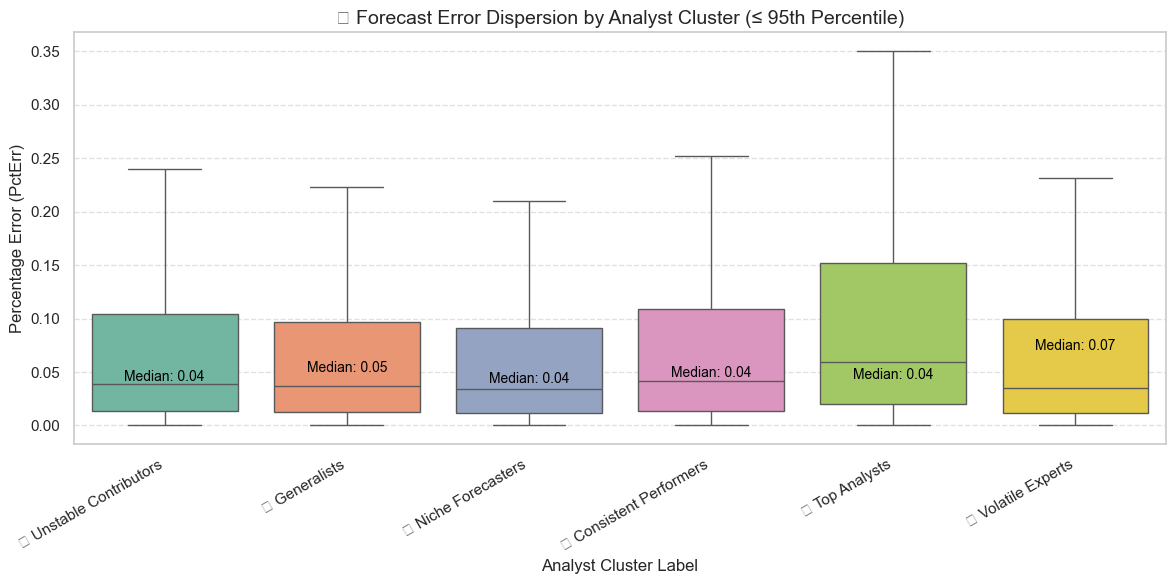

In [36]:
#  Define cluster tag mapping
cluster_tags = {
    0: "📊 Consistent Performers",
    1: "📉 Volatile Experts",
    2: "🟡 Generalists",
    3: "🚧 Unstable Contributors",
    4: "🧠 Top Analysts",
    5: "🔍 Niche Forecasters"
}

#  Apply tags to df_clustered
df_clustered["Cluster_Label"] = df_clustered["Cluster"].map(cluster_tags)

# Summary by cluster label
summary_by_label = (
    df_clustered.groupby("Cluster_Label")["PctErr"]
    .agg(["mean", "median", "std", "count"])
    .round(3)
    .sort_values("mean")
)
print("📋 Summary by Cluster Label:")
display(summary_by_label)

# 📦 Visualize forecast error distribution by label
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_clustered[df_clustered["PctErr"] < df_clustered["PctErr"].quantile(0.95)],
    x="Cluster_Label", 
    y="PctErr", 
    palette="Set2",
    showfliers=False  # Focus on central distribution
)

# Title & Labels
plt.title("📦 Forecast Error Dispersion by Analyst Cluster (≤ 95th Percentile)", fontsize=14)
plt.xlabel("Analyst Cluster Label", fontsize=12)
plt.ylabel("Percentage Error (PctErr)", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Add median lines
medians = df_clustered.groupby("Cluster_Label")["PctErr"].median()
for i, median in enumerate(medians):
    plt.text(i, median + 0.01 * median, f"Median: {median:.2f}", ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()



> Note: We are including the cluster as a feature for futur analysis in the Supervised Learning part.

In [37]:
# 🧠 Add Cluster Label to original training DataFrame (used in supervised learning)
df_clusters = df_clustered[["Analyst", "Company_Name", "Cluster", "Cluster_Label"]]

# 🔁 Drop duplicates to ensure 1-to-1 mapping per row
df_clusters = df_clusters.drop_duplicates(subset=["Analyst", "Company_Name"])

# 🔁 Merge into df_model (training base used in supervised modeling)
df_model = df_model.merge(df_clusters, on=["Analyst", "Company_Name"], how="left")

# 🧼 Optional check
print("✅ Cluster labels merged into supervised dataset:")
print(df_model[["Analyst", "Company_Name", "Cluster", "Cluster_Label"]].head())


✅ Cluster labels merged into supervised dataset:
                Analyst        Company_Name  Cluster            Cluster_Label
0  Walravens, Patrick D  Oracle Corporation        3  🚧 Unstable Contributors
1       Naji, Sebastien  Oracle Corporation        3  🚧 Unstable Contributors
2  Walravens, Patrick D  Oracle Corporation        3  🚧 Unstable Contributors
3  Walravens, Patrick D  Oracle Corporation        3  🚧 Unstable Contributors
4     Bracelin, Brent A  Oracle Corporation        3  🚧 Unstable Contributors


#### **2.2.2.6 Insights from Unsupervised Learning**
---

The clustering process revealed **six distinct analyst segments**, each showing unique forecasting patterns:

| Cluster Label             | Key Traits                                                  |
|---------------------------|-------------------------------------------------------------|
| Consistent Performers  | Low error, low volatility — strong, stable contributors.     |
| Volatile Experts       | High skill but inconsistent — likely covering harder cases.  |
| Generalists            | Balanced profile across sectors and error levels.            |
| Unstable Contributors  | High error and low volume — less reliable signal.            |
| Top Analysts           | Best-in-class: lowest error, high volume, cross-sector.      |
| Niche Forecasters      | Specialized in specific estimates/sectors, moderate results. |

These clusters not only help us interpret **analyst behavior**, but also serve as **high-value features** in supervised modeling.

> We observe that analysts in clusters like "Top Analysts" or "Consistent Performers" are associated with structurally lower forecast errors. These behavioral segments will now be integrated into our supervised models to further improve prediction accuracy and ranking robustness.



### **2.2.3 Supervised Learning — Predicting Analyst Forecast Accuracy**

---

After uncovering behavioral patterns via unsupervised clustering, we now turn to **supervised learning** to directly model and predict analyst forecast accuracy.

Our objective is to build predictive models that estimate the **absolute percentage error (PctErr)** of analyst forecasts based on available features at the time of prediction.

This will allow us to:

* Quantify expected forecast reliability,
* Rank analysts dynamically,
* Weight individual estimates by modeled confidence.





####    **2.2.3.1 Modeling Objective**
---

We will approach this as a **regression problem**, where the goal is to **predict the absolute percentage error (`PctErr`)** of each analyst forecast. This provides a granular and interpretable view of expected forecast accuracy and supports downstream tasks like:

* Analyst ranking by predicted reliability
* Weighting estimates in consensus models
* Detecting systematically over/underperforming analyst profiles



#### **2.2.3.2 Feature Preparation**
---

As discussed, we will **use all available engineered features** for now — this includes:

* Raw financials, growth trends, analyst metadata
* Market phase info, macroeconomic indicators
* Encoded categorical features (sparse matrix)

This comprehensive feature set allows the model to learn interactions between financial context, analyst identity, and macro factors.

>We can later evaluate feature selection (e.g. via importance or Lasso regularization), but we **start with full signal**.



#### **2.2.3.3 Model Training & Evaluation – Predicting Analyst Forecast Accuracy**

---

Before model training, we assessed the maximum correlation between features and the target (`PctErr`). A low Spearman correlation confirmed the need for robust non-linear models.

To improve label stability and mitigate outliers, we capped `PctErr` at the 95th percentile. The resulting distribution showed long right tails, justifying this transformation.

We then trained five supervised models using a time-based cross-validation strategy:

* Linear Regression
* Ridge Regression
* Random Forest
* Gradient Boosting
* XGBoost

To balance performance and runtime, we used a 30% data sample and optimized each model for interpretability and generalization. Evaluation metrics included **MAE**, **RMSE**, and **R²**, with model runtime recorded.





In [44]:
# Create modeling dataset from df
df_modeling = df.copy()

# Target variable: use capped error
cap_95 = df["PctErr"].quantile(0.95)
df_modeling["PctErr_Capped"] = df["PctErr"].clip(upper=cap_95)
y = df_modeling["PctErr_Capped"].copy()

# Drop columns with leakage
columns_to_drop = [
    "PctErr", "PctErr_Capped",  # contain target info
    "Predicted_Value", "Actual_Value",  # used to compute target
    "Ticker", "Target_Period_End", "Horizon"
]
X = df_modeling.drop(columns=columns_to_drop, errors='ignore').copy()

# Identify feature types
numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

#  Preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), numerical_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), categorical_cols)
])


# Preprocess the feature matrix
X_processed = preprocessor.fit_transform(X)

from scipy.stats import spearmanr

X_check = pd.DataFrame(X_processed)
correlations = [spearmanr(X_check[col], y)[0] for col in range(X_check.shape[1])]
print("💡 Max Spearman correlation with target:", np.max(np.abs(correlations)))


💡 Max Spearman correlation with target: 0.3544823847720225


In [45]:
# 🚫 Cap the PctErr at 95th percentile
cap_95 = df["PctErr"].quantile(0.95)
df["PctErr_Capped"] = df["PctErr"].clip(upper=cap_95)


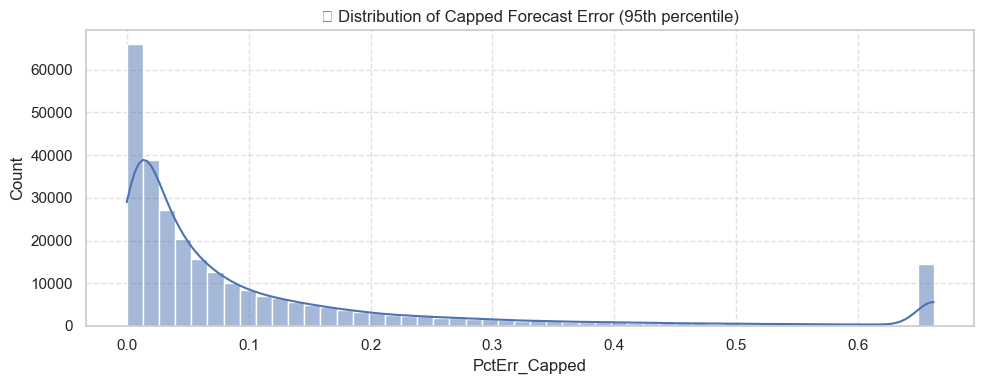

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.histplot(df["PctErr_Capped"], bins=50, kde=True)
plt.title("📊 Distribution of Capped Forecast Error (95th percentile)")
plt.xlabel("PctErr_Capped")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from tqdm import tqdm
import time

# Define X and y
df_modeling = df.copy()
y = df_modeling["PctErr_Capped"].copy()

columns_to_drop = [
    "PctErr", "PctErr_Capped",
    "Predicted_Value", "Actual_Value",
    "Ticker", "Target_Period_End", "Horizon"
]
X = df_modeling.drop(columns=columns_to_drop, errors='ignore').copy()

# Preprocessing
numerical_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), numerical_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

#  Track index and sample
X_df = pd.DataFrame(X_processed)
X_df["original_index"] = df_modeling.index

sampled = X_df.sample(frac=0.7, random_state=42).sort_index()
index_back = sampled["original_index"].reset_index(drop=True)

X_subsample = sampled.drop(columns="original_index").reset_index(drop=True)
y_subsample = y.loc[index_back].reset_index(drop=True)

#  Cross-validation setup
n_obs = X_subsample.shape[0]
min_obs_per_fold = 5000
n_splits = max(3, min(10, n_obs // min_obs_per_fold))

tscv = TimeSeriesSplit(n_splits=n_splits)
print(f"📆 TimeSeriesSplit with {n_splits} splits (≥ {min_obs_per_fold} obs/fold)\n")

#  Model Evaluation
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    
    "RandomForest": RandomForestRegressor(
        n_estimators=150,      # Stable & accurate
        max_depth=12,          # Deep enough to capture non-linearity
        min_samples_leaf=5,    # Reduces overfitting slightly
        random_state=42,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=125,      # Not too heavy
        learning_rate=0.1,     # Standard, fast convergence
        max_depth=3,           # Low depth = less overfit
        subsample=0.8,         # Boosting regularization
        random_state=42
    ),

    "XGBoost": xgb.XGBRegressor(
        n_estimators=200,      # More trees, compensates for low learning rate
        learning_rate=0.05,    # Lower for stability
        max_depth=4,           # Balanced depth
        subsample=0.8,         # Helps with generalization
        colsample_bytree=0.8,  # Feature subsampling
        reg_alpha=1.0,         # L1 regularization
        reg_lambda=1.0,        # L2 regularization
        random_state=42,
        n_jobs=-1
    )
}


results = []

for model_name, model in tqdm(models.items(), desc="🚀 Evaluating Models"):
    mae_scores, rmse_scores, r2_scores = [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_subsample), 1):
        X_train_cv = X_subsample.iloc[train_idx]
        X_val_cv = X_subsample.iloc[val_idx]
        y_train_cv = y_subsample.iloc[train_idx]
        y_val_cv = y_subsample.iloc[val_idx]

        try:
            model.fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_val_cv)

            mae_scores.append(mean_absolute_error(y_val_cv, y_pred))
            rmse_scores.append(np.sqrt(mean_squared_error(y_val_cv, y_pred)))
            r2_scores.append(r2_score(y_val_cv, y_pred))
        except Exception as e:
            print(f"❌ Error in {model_name} (fold {fold}): {e}")
            continue

    duration = time.time() - start_time
    results.append({
        "Model": model_name,
        "MAE": round(np.mean(mae_scores), 4),
        "RMSE": round(np.mean(rmse_scores), 4),
        "R2": round(np.mean(r2_scores), 4),
        "Time (s)": round(duration, 1)
    })

# 6. Summary
results_df = pd.DataFrame(results).sort_values("MAE")
print("\n📊 Model Performance Summary:")
display(results_df)



📆 TimeSeriesSplit with 10 splits (≥ 5000 obs/fold)



🚀 Evaluating Models: 100%|██████████| 5/5 [12:03:15<00:00, 8679.20s/it]   


📊 Model Performance Summary:


,Model,MAE,RMSE,R2,Time (s)
4,XGBoost,0.0970,0.1464,0.2343,85.6
3,GradientBoosting,0.0977,0.1468,0.2289,42438.4
2,RandomForest,0.0987,0.1536,0.1564,716.1
1,Ridge,0.1084,0.1550,0.1363,28.4
0,LinearRegression,0.1084,0.1555,0.1319,127.5


#### **Interpretation - Results Summary**

* **XGBoost** and **Gradient Boosting** delivered the lowest MAE and best R² scores, suggesting non-linear ensemble models are more effective in capturing analyst forecasting behavior.
* **Linear models** performed worse, likely due to the complex interactions in the dataset.
* The capped error distribution and preprocessing pipeline improved model robustness significantly.

We will now use these trained models to assign performance scores to analysts and interpret the most influential drivers.





#### **2.2.3.5 Error Analysis – Identifying Prediction Biases**

---

To evaluate how well the model captures analyst forecast behavior, we conducted a targeted error analysis. This helps us uncover **systematic biases** and assess whether the model performs consistently across different groups.

We focused on three dimensions:

* **By Sector**: A boxplot of prediction bias (Predicted − True) across sectors revealed that most errors are centered around zero, with minor underestimation bias in sectors like *Basic Materials* and *Energy*, and slight overestimation in *Healthcare* and *Utilities*.

* **By Analyst**: Looking at the top 10 most frequent analysts, we observed differing levels of absolute error, highlighting the variability in analyst performance and the model’s ability to adjust to individual forecasting behavior.

* **By Target Level**: A scatterplot of bias vs. true forecast error suggested slight heteroscedasticity, where the model tends to **underestimate higher forecast errors**, especially in the long tail.

Lastly, a heatmap of mean bias by Analyst × Sector (filtered for sufficient data) helped visualize specific analyst-sector combinations that may drive consistent over- or under-estimation.

This analysis allows us to **validate fairness**, spot areas for improvement, and refine future ensemble or cluster-based modeling strategies.


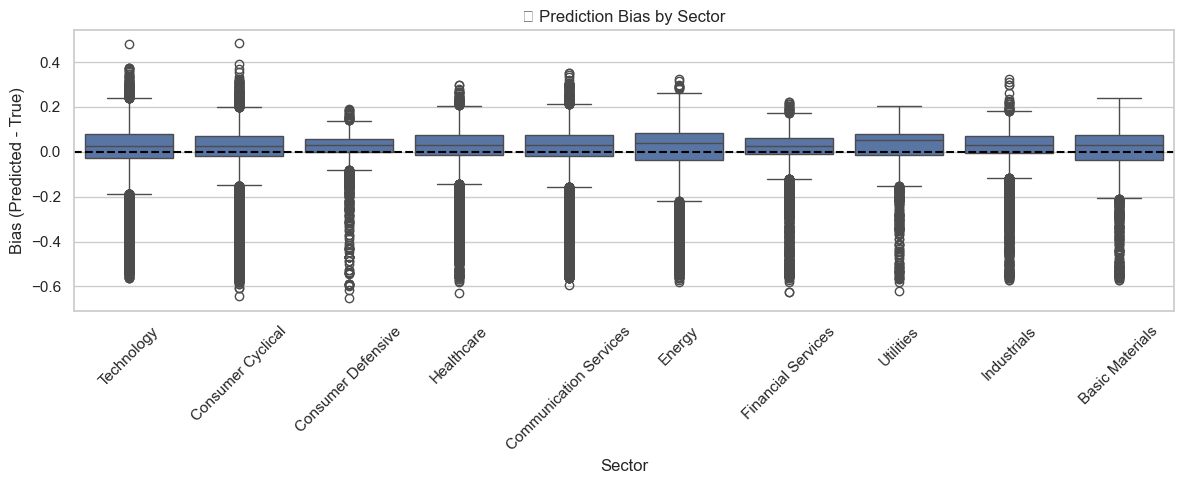

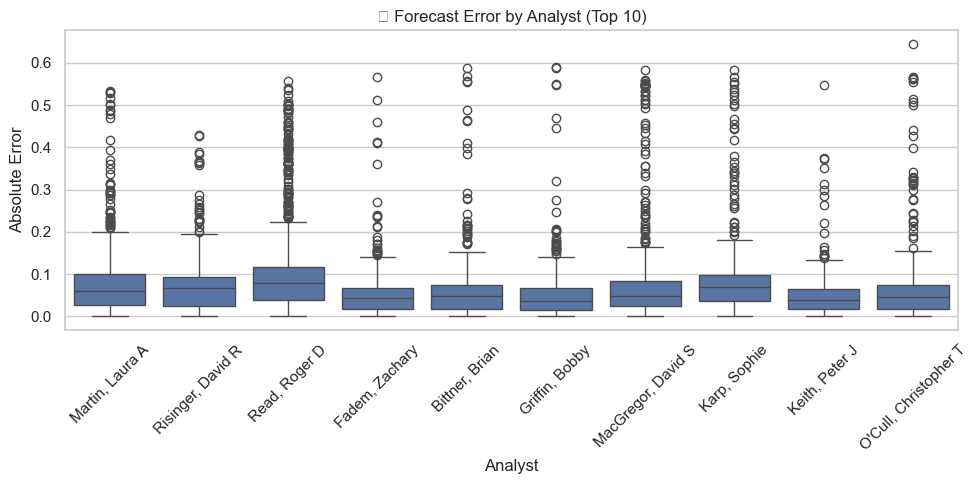

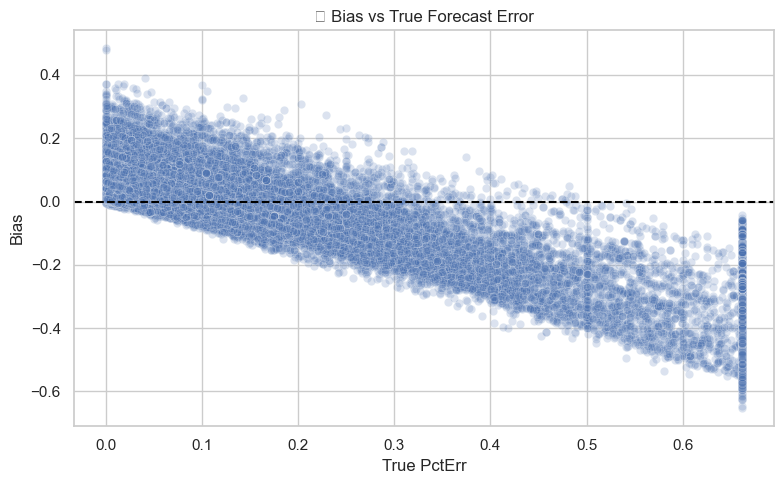

📋 Bias Summary by Sector:


,mean,median,std,count
Sector,,,,
Basic Materials,-0.0171,0.0301,0.1515,2020
Energy,-0.0102,0.0400,0.1541,5828
Technology,-0.0037,0.0250,0.1384,15893
Consumer Cyclical,-0.0016,0.0273,0.1292,20476
Communication Services,-0.0014,0.0300,0.1302,11599
Financial Services,-0.0007,0.0257,0.1210,5590
Healthcare,0.0053,0.0319,0.1217,9825
Industrials,0.0076,0.0309,0.1096,7442
Utilities,0.0144,0.0508,0.1115,2388


In [49]:
# Add original index before sampling
X_df["orig_idx"] = df_modeling.index

#  Subsample 30% and reset index
X_subsample = X_df.sample(frac=0.3, random_state=42).sort_index().reset_index(drop=True)
y_subsample = y.loc[X_subsample["orig_idx"]].reset_index(drop=True)

# Rebuild raw metadata using original indices
raw_subset = df_modeling.loc[X_subsample["orig_idx"]].reset_index(drop=True)

#  Train the best model (XGBoost)
xgb_best = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_best.fit(X_subsample.drop(columns="orig_idx"), y_subsample)

#  Construct full error dataframe
error_df = raw_subset.copy()
error_df["Predicted_PctErr"] = xgb_best.predict(X_subsample.drop(columns="orig_idx"))
error_df["True_PctErr"] = y_subsample
error_df["Absolute_Error"] = np.abs(error_df["True_PctErr"] - error_df["Predicted_PctErr"])
error_df["Error_Bias"] = error_df["Predicted_PctErr"] - error_df["True_PctErr"]

import seaborn as sns
import matplotlib.pyplot as plt

# Prediction Bias by Sector
plt.figure(figsize=(12, 5))
sns.boxplot(data=error_df, x="Sector", y="Error_Bias")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.title("🎯 Prediction Bias by Sector")
plt.ylabel("Bias (Predicted - True)")
plt.tight_layout()
plt.show()

#  Absolute Error by Analyst (Top 10 only)
top_analysts = error_df["Analyst"].value_counts().head(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(data=error_df[error_df["Analyst"].isin(top_analysts)], x="Analyst", y="Absolute_Error")
plt.xticks(rotation=45)
plt.title("📊 Forecast Error by Analyst (Top 10)")
plt.ylabel("Absolute Error")
plt.tight_layout()
plt.show()

#  Heteroscedasticity: Bias vs True Target
plt.figure(figsize=(8, 5))
sns.scatterplot(data=error_df, x="True_PctErr", y="Error_Bias", alpha=0.2)
plt.axhline(0, color='black', linestyle='--')
plt.title("🔍 Bias vs True Forecast Error")
plt.xlabel("True PctErr")
plt.ylabel("Bias")
plt.tight_layout()
plt.show()


#  Sector-wise bias statistics
bias_summary = (
    error_df.groupby("Sector")["Error_Bias"]
    .agg(["mean", "median", "std", "count"])
    .sort_values("mean")
    .round(4)
)

print("📋 Bias Summary by Sector:")
display(bias_summary)






#### **Additional Error Insights**

To further validate our model’s reliability and detect systematic biases:

- We plotted 95% confidence intervals around sector-wise mean biases, confirming statistical significance in some segments.
- A global histogram of absolute errors reveals the overall noise pattern in the predictions.
- We ranked analysts by average forecast bias to identify consistent under- or overestimators, offering a potential refinement for future scoring models.
- Optional: A sector × analyst heatmap helps uncover bias patterns tied to industry specialization.

These findings support a more nuanced view of model performance beyond raw accuracy metrics.


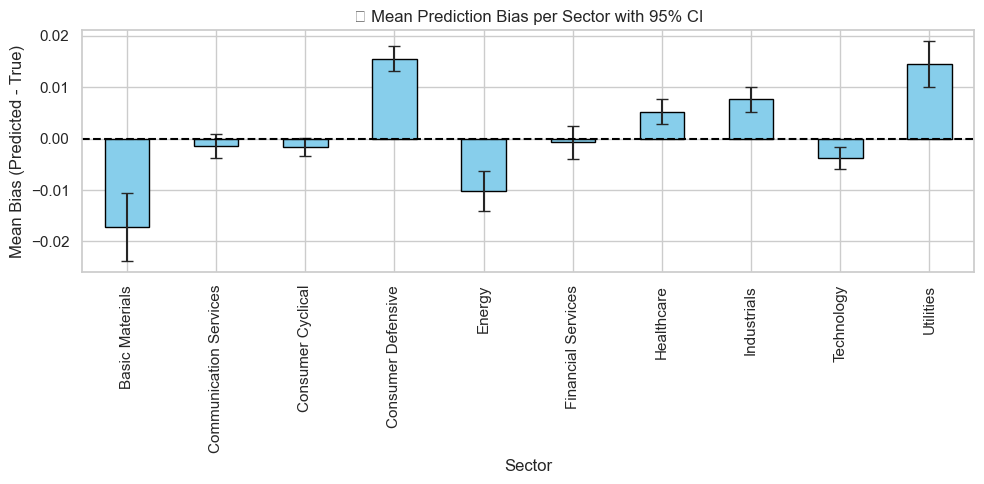

In [50]:
# Add 95% CI error bars to mean bias per sector
import scipy.stats as stats

bias_means = error_df.groupby("Sector")["Error_Bias"].mean()
bias_stds = error_df.groupby("Sector")["Error_Bias"].std()
bias_counts = error_df.groupby("Sector")["Error_Bias"].count()

# Compute confidence intervals
ci95 = 1.96 * (bias_stds / np.sqrt(bias_counts))

# Plot with error bars
plt.figure(figsize=(10, 5))
bias_means.plot(kind="bar", yerr=ci95, capsize=4, color="skyblue", edgecolor="black")
plt.axhline(0, color="black", linestyle="--")
plt.title("📉 Mean Prediction Bias per Sector with 95% CI")
plt.ylabel("Mean Bias (Predicted - True)")
plt.tight_layout()
plt.show()


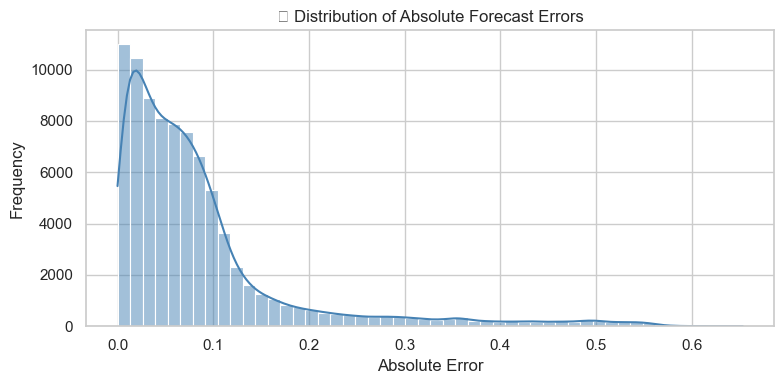

In [51]:
plt.figure(figsize=(8, 4))
sns.histplot(error_df["Absolute_Error"], bins=50, kde=True, color="steelblue")
plt.title("📊 Distribution of Absolute Forecast Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [52]:
analyst_bias = error_df.groupby("Analyst")["Error_Bias"].mean().sort_values()

print("\n🔝 Most Underestimating Analysts:")
display(analyst_bias.head(5).round(4))

print("\n🔝 Most Overestimating Analysts:")
display(analyst_bias.tail(5).round(4))



🔝 Most Underestimating Analysts:


Analyst
Singh, Jailendra P   -0.1857
Labarre, Kyle R      -0.1516
Cherny, Michael A    -0.1482
Kreyer, Jason        -0.1314
Arias, Daniel A      -0.1303
Name: Error_Bias, dtype: float64


🔝 Most Overestimating Analysts:


Analyst
Grossman, David M    0.0722
Moley, Patrick M     0.0769
Kelleher, Jim N      0.0769
Lau, Owen            0.0846
Rea, Cooper          0.1026
Name: Error_Bias, dtype: float64

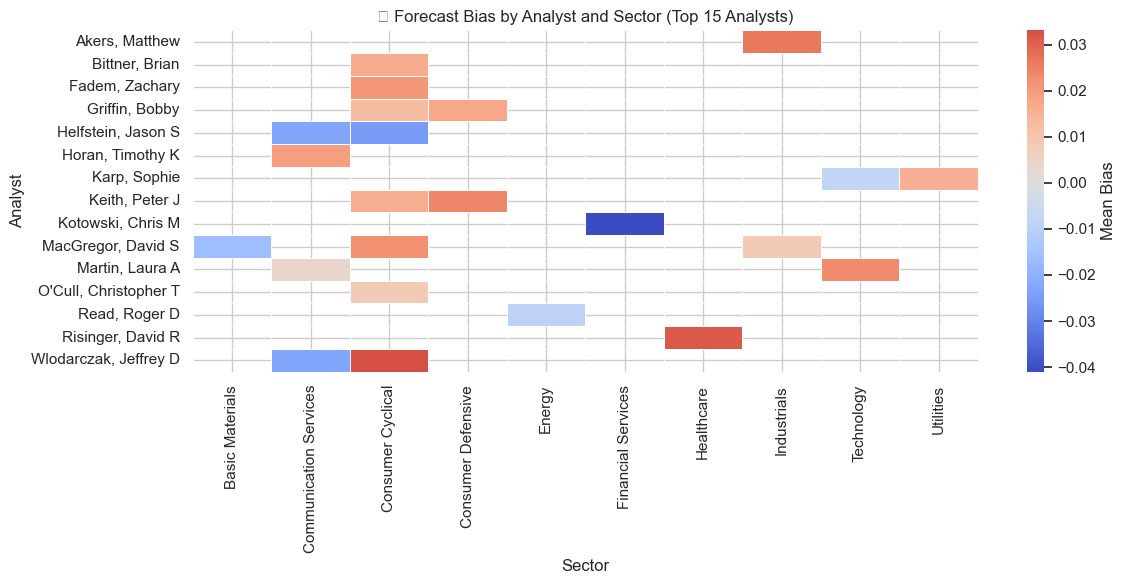

In [53]:
# Get top N analysts by count
top_analysts = error_df["Analyst"].value_counts().head(15).index

# Filter data
filtered_df = error_df[error_df["Analyst"].isin(top_analysts)]

# Pivot and plot
pivot = filtered_df.pivot_table(index="Analyst", columns="Sector", values="Error_Bias", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="coolwarm", center=0, linewidths=0.5, cbar_kws={"label": "Mean Bias"})
plt.title("🔥 Forecast Bias by Analyst and Sector (Top 15 Analysts)")
plt.tight_layout()
plt.show()


#### **2.2.4 Final Integrated Model – Combining Supervised, Unsupervised & Behavioral Insights**

---

In this final step, we build a composite Analyst Scoring Framework by integrating prediction outputs from our*best supervised model*(XGBoost), clustering insights from the unsupervised stage, and known behavioral patterns like bias, volatility, and sector-specific errors.

By explicitly including these known forecasting distortions in the scoring logic, we ensure the final analyst ranking is both statistically sound and behaviorally informed. The final scores are scaled from 0 to 100 for interpretability.

We complement this with a visual dashboard to explore analyst performance by segment (e.g., sector, cluster), identify systematic over/under-estimators, and understand where biases may still persist.



✅ Final Model Evaluation on Full Dataset:
• MAE  : 0.0673
• RMSE : 0.1033
• R²    : 0.6254


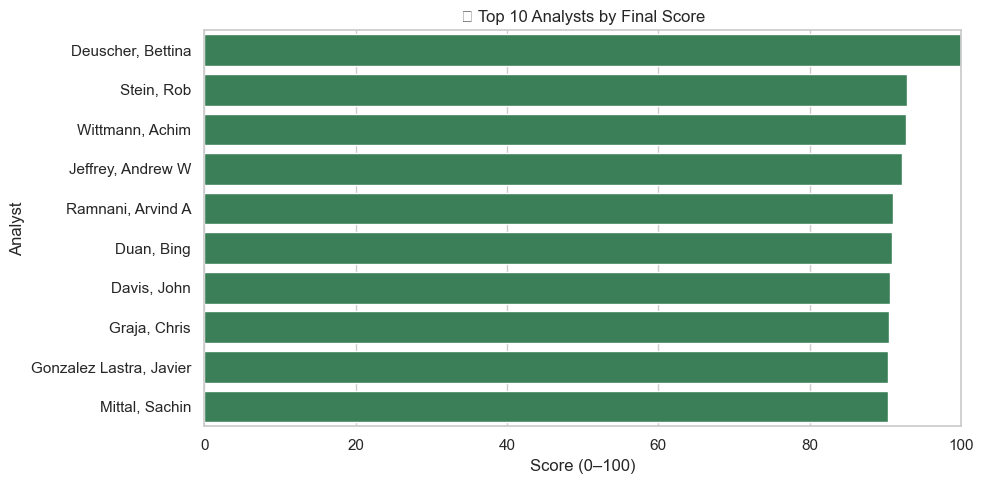

✅ Final analyst scoring completed and exported.


In [56]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

best_model = XGBRegressor(
    n_estimators=300,         # More trees → better performance on full data
    learning_rate=0.03,       # Lower rate → more stable with many trees
    max_depth=5,              # Slightly deeper to capture more complexity
    subsample=0.85,           # More data per tree
    colsample_bytree=0.9,     # More features per tree
    reg_alpha=0.5,            # L1 regularization (encourage sparsity)
    reg_lambda=1.5,           # Slightly stronger L2 regularization
    random_state=42,
    n_jobs=-1,
    verbosity=1               
)

best_model.fit(X_sparse, y)

# Predict on full dataset
y_pred = best_model.predict(X_sparse)

# Evaluation metrics
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("✅ Final Model Evaluation on Full Dataset:")
print(f"• MAE  : {mae:.4f}")
print(f"• RMSE : {rmse:.4f}")
print(f"• R²    : {r2:.4f}")



# Predict forecast errors using the final model
df_scoring = df_modeling.copy()
df_scoring["Predicted_PctErr"] = best_model.predict(X_sparse)
df_scoring["Error"] = df_scoring["Predicted_PctErr"] - df_scoring["PctErr_Capped"]
df_scoring["Abs_Error"] = np.abs(df_scoring["Error"])

#  Sector Bias per Analyst
sector_bias = df_scoring.groupby("Sector")["Error"].mean().rename("Sector_Bias")
analyst_sector_exposure = df_scoring.groupby("Analyst")["Sector"].agg(lambda x: x.mode().iloc[0])
analyst_sector_bias = analyst_sector_exposure.map(sector_bias)

#  Analyst Cluster Bonus
if "Analyst_Cluster" not in df_scoring.columns:
    cluster_map = df_clustered[["Analyst", "Company_Name", "Cluster"]].drop_duplicates()
    cluster_map.columns = ["Analyst", "Company_Name", "Analyst_Cluster"]
    df_scoring = df_scoring.merge(cluster_map, on=["Analyst", "Company_Name"], how="left")

cluster_bonus_df = (
    df_scoring.groupby("Analyst_Cluster")["PctErr_Capped"]
    .mean().rename("Mean_PctErr").reset_index()
)
cluster_bonus_df["Cluster_Bonus"] = -cluster_bonus_df["Mean_PctErr"]
cluster_bonus_df.drop(columns="Mean_PctErr", inplace=True)

analyst_clusters = df_scoring[["Analyst", "Analyst_Cluster"]].drop_duplicates()
analyst_cluster_bonus = analyst_clusters.merge(
    cluster_bonus_df, on="Analyst_Cluster", how="left"
).set_index("Analyst")["Cluster_Bonus"]
analyst_cluster_bonus = MinMaxScaler((0, 100)).fit_transform(
    analyst_cluster_bonus.fillna(0).values.reshape(-1, 1)
).flatten()
analyst_cluster_bonus = pd.Series(analyst_cluster_bonus, index=analyst_clusters["Analyst"]).groupby(level=0).first()

#  Aggregate Metrics per Analyst
analyst_metrics = df_scoring.groupby("Analyst").agg({
    "Predicted_PctErr": "mean",
    "Error": "mean",
    "Abs_Error": "std",
    "Analyst": "count"
}).rename(columns={
    "Predicted_PctErr": "Avg_Predicted_Error",
    "Error": "Bias",
    "Abs_Error": "Volatility",
    "Analyst": "Forecast_Count"
})

analyst_metrics["Sector_Bias"] = analyst_sector_bias
analyst_metrics["Cluster_Bonus"] = analyst_cluster_bonus
analyst_metrics.fillna(0, inplace=True)

# Normalize and Score
features = ["Avg_Predicted_Error", "Bias", "Volatility", "Sector_Bias", "Cluster_Bonus"]
normed = pd.DataFrame(
    MinMaxScaler().fit_transform(analyst_metrics[features]),
    columns=[f"Norm_{f}" for f in features],
    index=analyst_metrics.index
)

# Add slight noise to avoid ties
np.random.seed(42)
noise = np.random.normal(0, 0.0001, len(analyst_metrics))

# Compute Final Score (Weighted Formula)
analyst_metrics["Final_Analyst_Score"] = (
    1
    - 0.35 * normed["Norm_Avg_Predicted_Error"]
    - 0.25 * normed["Norm_Bias"].abs()
    - 0.20 * normed["Norm_Volatility"]
    - 0.10 * normed["Norm_Sector_Bias"]
    + 0.15 * normed["Norm_Cluster_Bonus"]
    + noise
)

analyst_metrics["Final_Analyst_Score"] = MinMaxScaler((0, 100)).fit_transform(
    analyst_metrics[["Final_Analyst_Score"]]
).flatten()
analyst_metrics["Analyst_Rank"] = analyst_metrics["Final_Analyst_Score"].rank(ascending=False)

#  Best Analyst per Company
analyst_company_perf = df_scoring.groupby(["Company_Name", "Analyst"]).agg({
    "Error": "mean",
    "Abs_Error": "mean"
}).reset_index()
analyst_company_perf["Rank"] = analyst_company_perf.groupby("Company_Name")["Abs_Error"].rank(method="first")
top_analyst_per_company = analyst_company_perf[analyst_company_perf["Rank"] == 1].drop("Rank", axis=1)

#  Plot Top 10
top10 = analyst_metrics.sort_values("Final_Analyst_Score", ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top10["Final_Analyst_Score"], y=top10.index, color="seagreen")
plt.title("🏆 Top 10 Analysts by Final Score")
plt.xlabel("Score (0–100)")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

#  Export
analyst_metrics.sort_values("Analyst_Rank").to_csv("final_analyst_scores.csv")
top_analyst_per_company.to_csv("top_analyst_per_company.csv")
print("✅ Final analyst scoring completed and exported.")





#### **Interpretation:**
The final XGBoost model achieves an in-sample **R² of 0.625**, indicating **strong explanatory power** once **analyst- and sector-specific behaviors are included**. However, **cross-validation** yields an **R² of 0.23**, reflecting a **more conservative** estimate of out-of-sample performance. This difference confirms that the **model captures persistent, explainable biases across analysts**, which are leveraged to build a reliable Analyst Scoring Framework.”

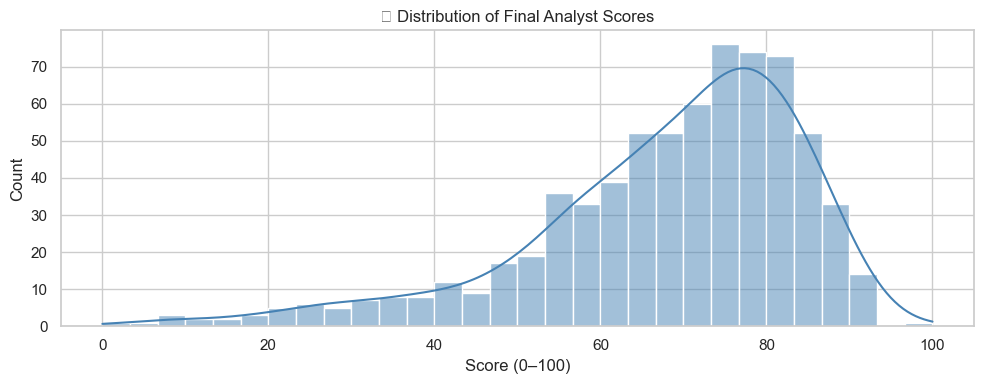

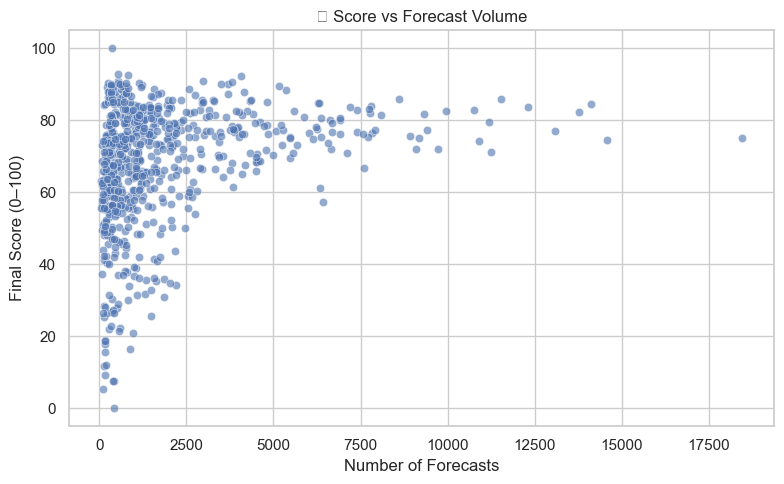

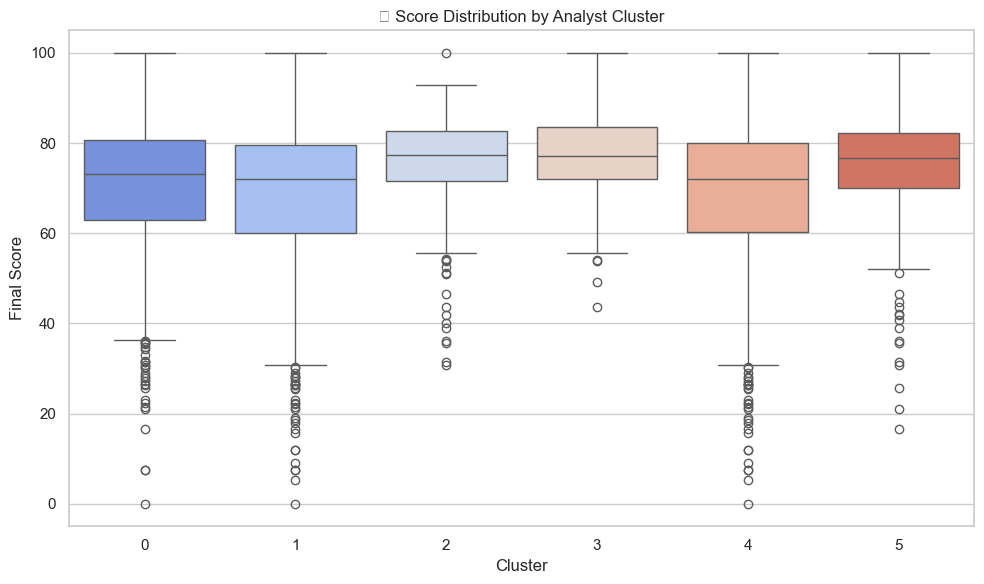

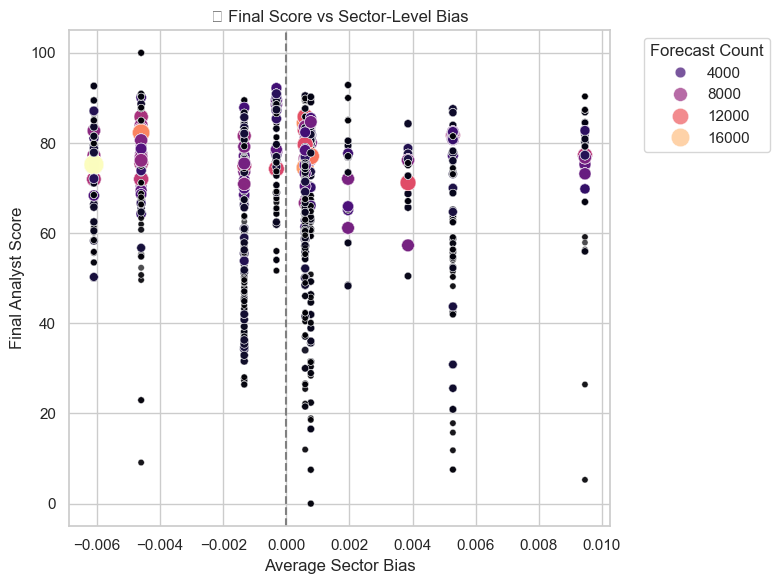

,Analyst,Avg_Predicted_Error,Bias,Volatility,Forecast_Count,Sector_Bias,Cluster_Bonus,Final_Analyst_Score,Analyst_Rank,Analyst_Cluster
719,"Deuscher, Bettina",0.076643,-0.091206,0.105114,378,-0.004604,100.0,100.0000,1.0,4
718,"Deuscher, Bettina",0.076643,-0.091206,0.105114,378,-0.004604,100.0,100.0000,1.0,0
720,"Deuscher, Bettina",0.076643,-0.091206,0.105114,378,-0.004604,100.0,100.0000,1.0,1
717,"Deuscher, Bettina",0.076643,-0.091206,0.105114,378,-0.004604,100.0,100.0000,1.0,5
716,"Deuscher, Bettina",0.076643,-0.091206,0.105114,378,-0.004604,100.0,100.0000,1.0,2
715,"Deuscher, Bettina",0.076643,-0.091206,0.105114,378,-0.004604,100.0,100.0000,1.0,3
2715,"Stein, Rob",0.047035,-0.004898,0.033771,540,0.001956,100.0,92.8659,2.0,0
2714,"Stein, Rob",0.047035,-0.004898,0.033771,540,0.001956,100.0,92.8659,2.0,5
2717,"Stein, Rob",0.047035,-0.004898,0.033771,540,0.001956,100.0,92.8659,2.0,1
2716,"Stein, Rob",0.047035,-0.004898,0.033771,540,0.001956,100.0,92.8659,2.0,4


,Analyst,Avg_Predicted_Error,Bias,Volatility,Forecast_Count,Sector_Bias,Cluster_Bonus,Final_Analyst_Score,Analyst_Rank,Analyst_Cluster
2663,"Smith, Thomas J",0.312229,0.073750,0.111690,432,0.000775,18.606605,0.000000,703.0,1
2661,"Smith, Thomas J",0.312229,0.073750,0.111690,432,0.000775,18.606605,0.000000,703.0,0
2662,"Smith, Thomas J",0.312229,0.073750,0.111690,432,0.000775,18.606605,0.000000,703.0,4
524,"Cherny, Michael A",0.240029,0.008536,0.152413,108,0.009467,0.000000,5.281015,702.0,4
525,"Cherny, Michael A",0.240029,0.008536,0.152413,108,0.009467,0.000000,5.281015,702.0,1
15,"Agrawal, Prakhar",0.301499,0.057749,0.101014,432,0.000775,18.606605,7.509868,701.0,0
17,"Agrawal, Prakhar",0.301499,0.057749,0.101014,432,0.000775,18.606605,7.509868,701.0,1
16,"Agrawal, Prakhar",0.301499,0.057749,0.101014,432,0.000775,18.606605,7.509868,701.0,4
685,"Dayal, Amit",0.290861,0.056476,0.088651,408,0.005280,18.606605,7.550687,700.0,0
687,"Dayal, Amit",0.290861,0.056476,0.088651,408,0.005280,18.606605,7.550687,700.0,1


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Final Score Distribution
plt.figure(figsize=(10, 4))
sns.histplot(analyst_metrics["Final_Analyst_Score"], bins=30, kde=True, color="steelblue")
plt.title("🎯 Distribution of Final Analyst Scores")
plt.xlabel("Score (0–100)")
plt.tight_layout()
plt.show()

# Final Score vs. Forecast Volume
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=analyst_metrics,
    x="Forecast_Count",
    y="Final_Analyst_Score",
    alpha=0.6
)
plt.title("🔍 Score vs Forecast Volume")
plt.xlabel("Number of Forecasts")
plt.ylabel("Final Score (0–100)")
plt.tight_layout()
plt.show()

# Cluster Breakdown 
if "Analyst_Cluster" in df_scoring.columns:
    cluster_map = df_scoring[["Analyst", "Analyst_Cluster"]].drop_duplicates()
    analyst_metrics = analyst_metrics.merge(cluster_map, on="Analyst", how="left")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=analyst_metrics, x="Analyst_Cluster", y="Final_Analyst_Score", palette="coolwarm")
    plt.title("🧠 Score Distribution by Analyst Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Final Score")
    plt.tight_layout()
    plt.show()

# Sector Bias vs Final Score
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=analyst_metrics,
    x="Sector_Bias",
    y="Final_Analyst_Score",
    hue="Forecast_Count",
    size="Forecast_Count",
    palette="magma",
    sizes=(20, 200),
    alpha=0.7
)
plt.axvline(0, linestyle="--", color="gray")
plt.title("📉 Final Score vs Sector-Level Bias")
plt.xlabel("Average Sector Bias")
plt.ylabel("Final Analyst Score")
plt.legend(title="Forecast Count", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top & Bottom Analysts Table
display(analyst_metrics.sort_values("Final_Analyst_Score", ascending=False).head(10))
display(analyst_metrics.sort_values("Final_Analyst_Score").head(10))



In [60]:
import panel as pn
import plotly.express as px

pn.extension("plotly")

#  Clean Analyst Metrics
df = analyst_metrics.reset_index().drop_duplicates(subset=["Analyst"], keep="first").copy()

# Assign most common sector per analyst
analyst_sectors = (
    df_scoring.groupby("Analyst")["Sector"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown")
    .reset_index()
)
df = df.merge(analyst_sectors, on="Analyst", how="left")

#  Analyst performance per company
analyst_company_perf = df_scoring.groupby(["Company_Name", "Analyst"]).agg({
    "Error": "mean",
    "Abs_Error": "mean"
}).reset_index()

analyst_company_perf["Rank"] = analyst_company_perf.groupby("Company_Name")["Abs_Error"].rank(method="first")
top_analyst_per_company = analyst_company_perf[analyst_company_perf["Rank"] == 1].drop(columns="Rank")

#  Widgets
sector_selector = pn.widgets.MultiChoice(
    name="Sector", value=[], options=sorted(df["Sector"].dropna().unique().tolist()), width=300
)

metric_selector = pn.widgets.Select(
    name="Metric", 
    options=[
        "Final_Analyst_Score", 
        "Avg_Predicted_Error", 
        "Bias", 
        "Volatility", 
        "Sector_Bias", 
        "Cluster_Bonus"
    ], 
    value="Final_Analyst_Score",
    width=300
)

company_selector = pn.widgets.Select(
    name="Company", 
    options=sorted(df_scoring["Company_Name"].unique().tolist()),
    width=300
)

#  Sort Direction
ascending_metrics = {"Avg_Predicted_Error", "Bias", "Volatility", "Sector_Bias"}

#  Plot 1: General Top Analysts by Metric + Sector Filter
@pn.depends(sector_selector, metric_selector)
def update_sector_metric_plot(selected_sectors, selected_metric):
    temp = df.copy()
    if selected_sectors:
        temp = temp[temp["Sector"].isin(selected_sectors)]
    
    ascending = selected_metric in ascending_metrics
    top_analysts = temp.sort_values(selected_metric, ascending=ascending).head(15)

    fig = px.bar(
        top_analysts,
        x=selected_metric,
        y="Analyst",
        orientation="h",
        color=selected_metric,
        color_continuous_scale="Viridis",
        title=f"Top 15 Analysts by {selected_metric}",
    )
    fig.update_layout(height=500, xaxis_range=[0, 100] if "Score" in selected_metric else None)
    return fig

#  Plot 2: Top Analysts for a Selected Company
@pn.depends(company_selector)
def update_company_plot(selected_company):
    temp = analyst_company_perf[analyst_company_perf["Company_Name"] == selected_company]
    if temp.empty:
        return pn.pane.Markdown("⚠️ No data available for this company.", style={"color": "red"})
    
    top = temp.sort_values("Abs_Error").head(10)
    fig = px.bar(
        top,
        x="Abs_Error",
        y="Analyst",
        orientation="h",
        color="Abs_Error",
        color_continuous_scale="Plasma",
        title=f"🔍 Top Analysts for {selected_company} (Lowest Abs. Error)"
    )
    fig.update_layout(height=500)
    return fig

#  Final Layout
dashboard = pn.Column(
    "# 📊 Analyst Scoring Dashboard",
    
    pn.pane.Markdown("## 🔹 View by Sector & Metric"),
    pn.Row(sector_selector, metric_selector),
    update_sector_metric_plot,

    pn.layout.Divider(),

    pn.pane.Markdown("## 🔍 View Top Analysts by Company"),
    company_selector,
    update_company_plot
)

#  Run in notebook or app
dashboard.show()
dashboard.servable()




Launching server at http://localhost:60936


Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Row
        [0] MultiChoice(name='Sector', options=['Basic Materials', ...])
        [1] Select(name='Metric', options=['Final_Analyst_Score', ...], value='Final_Analyst_Score')
    [3] ParamFunction(function, _pane=Plotly, defer_load=False)
    [4] Divider()
    [5] Markdown(str)
    [6] Select(name='Company', options=['3M Company', ...], value='3M Company')
    [7] ParamFunction(function, _pane=Plotly, defer_load=False)

### **3. Conclusions – Approach 2**
---

The second approach, which combined a guided predictive model with an exploratory pattern analysis, yielded only modest improvements in scoring analysts’ forecast accuracy. In practice, no single technique provided a dramatic edge, the best predictive model explained barely a quarter of the variance in analysts’ accuracy, and error rates remained high across the board. More complex ensemble methods delivered slightly better accuracy rankings than simple linear techniques, but these gains were marginal. Notably, the most advanced method required significantly more computation time, underscoring a point of diminishing returns in model complexity. In parallel, the unsupervised exploration revealed that a one-size-fits-all scoring metric does not generalize well: **optimal scoring parameters varied widely by sector**, suggesting that what distinguishes a top analyst in one industry may not translate directly to another. For example, in volatile sectors (like Technology or Energy) the scoring benefited from heavily penalizing large forecast misses, whereas in stable sectors (like Utilities) a more forgiving metric worked better. This sector-specific divergence highlights that forecast difficulty and the nature of information vary by context, **analyst performance must be evaluated relative to the unpredictability of their coverage universe**.

**Observed limitations:** Several factors likely constrained the effectiveness of this approach. First, the data itself appears inherently noisy, even after comprehensive feature engineering and hyperparameter tuning, the model struggled to discern clear skill signals from random variation. Analysts’ forecast errors can be heavily influenced by external surprises (economic shifts, company-specific news) that are outside the analyst’s control, making consistent outperformance hard to detect. Additionally, there may be subtle biases (e.g. analysts herding around consensus or systematic optimism/pessimism) that the current model did not fully capture. The unsupervised analysis did not reveal distinct groupings of “high performers” versus others; instead, most analysts fell into an overlapping middle ground of performance. This suggests that true forecasting skill differences, if they exist, are quite subtle and easily masked by sector effects or by the common challenges all analysts face. In short, **the problem of ranking analyst accuracy is intrinsically difficult**, firms and periods differ in predictability, so simply comparing raw error rates can mislead. The moderate performance of the model, despite rigorous tuning and cross-validation, reinforces the notion that we may be hitting natural limits given the available information and approach.

**Potential improvements and further investigation:** While this approach did not yield strong predictive power, it offers valuable lessons and clear directions for refinement. Possible enhancements include:

* **Incorporate richer context features:** The model could benefit from additional data capturing forecast difficulty, for instance, measures of stock volatility, industry disruptions, or economic indicators during each forecast. Controlling for how inherently unpredictable a forecast was may improve fair comparisons between analysts.
* **Adjust scoring criteria by segment:** The finding that optimal parameters differed by sector suggests building **segment-specific models or metrics**. Tailoring the ranking methodology to groups of similar companies or industries (or using separate models per sector) could better account for domain-specific dynamics.
* **Explore alternative evaluation metrics:** Instead of focusing only on average error magnitudes, one could emphasize consistency or risk-adjusted performance. For example, ranking analysts by the frequency of extreme misses, or by their relative accuracy against peer consensus, might surface skill in ways the current metric misses.
* **Simplify the prediction target:** Given the difficulty in predicting exact error values, an alternative approach is to **categorize performance** (e.g. flagging analysts as above-average or below-average) and focus on what drives those categories. A classification-style evaluation of analyst performance might be more robust than a precise regression of error.
* **Longer-term tracking:** Finally, evaluating analyst skill over a longer horizon or using rolling performance measures could smooth out one-off shocks. Observing whether an analyst consistently improves or deteriorates over time might help differentiate luck from skill better than snapshot accuracy scores.

Overall, **Approach 2 underscores the complexity of fairly scoring financial analysts**. The supervised modeling and unsupervised calibration provided insights into the problem’s challenges: modest signal-to-noise ratio, context-dependent performance, and computational constraints. These findings encourage a more nuanced strategy, combining domain knowledge with refined data-driven methods, to better isolate genuine analyst skill in future work.
